In [388]:
import sys
import os

# Add the parent directory of src to the system path
sys.path.append(os.path.abspath('../src'))


from sklearn.decomposition import PCA
from sklearn.cluster import k_means
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
#from numba import jit,prange
from model.model import GCN

import time
import utils as ut
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

scoring = {'mae': 'neg_mean_absolute_error',
           'mse': 'neg_mean_squared_error',
          'r2' : 'r2'} 

In [389]:
def runs(dx, max_m):
    # FOR HEAD MOTION
    merged_df,merged_phenotypic  = ut.read_motion()

    # Health subjects
    merged_phenotypic = merged_phenotypic[merged_phenotypic['DX'] == dx]
    merged_phenotypic = merged_phenotypic[merged_phenotypic[' Max Rotation (degree)'] < max_m]
    merged_phenotypic = merged_phenotypic[merged_phenotypic['Max Motion (mm)'] < max_m]


    #merged_df = merged_df.set_index(['Institution', 'Subject', 'Run'])
    #merged_phenotypic = merged_phenotypic.set_index(['Institution', 'Subject', 'Run'])
    common_indices = merged_df.index.intersection(merged_phenotypic.index)
    merged_phenotypic = merged_phenotypic.loc[common_indices,:]
    merged_df = merged_df.loc[common_indices,:]
    merged_df = merged_df.reset_index()
    merged_phenotypic = merged_phenotypic.reset_index()


    X_fmri = merged_df.iloc[:,14:]
    X_fmri = np.tanh(X_fmri)

    # Shuffle
    #X_fmri = X_fmri.sample(frac=1, axis=1)  # `frac=1` means to return all columns

    y = merged_df['Max Motion (mm)']
    y = merged_phenotypic['Age']


    A = ut.reconstruct_symmetric_matrix(190, X_fmri.iloc[:,:].mean(axis=0))
    train_data, val_data = ut.create_graph(X_fmri, X_fmri, y, y,method={'knn_group' : ut.compute_KNN_graph(A, 15)})#, method={'threshold': 0.8})
    train_loader, val_loader = ut.create_batch(train_data, val_data, batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = GCN(190, 3).to(device)
    #model.load_state_dict(torch.load('/Users/rodrigo/Post-Grad/Ising_GNN/Data/model_params_190.pth'))
    #model.load_state_dict(torch.load('/Users/rodrigo/Post-Grad/Ising_GNN/Data/model_params_190_TRUE.pth'))
    model.load_state_dict(torch.load('/Users/rodrigo/Post-Grad/Ising_GNN/Data/model_params_190_mae.pth'))

    model.eval()

    y_pred_aux_age = []
    for y_i in val_loader:
        y_pred_aux_age.append((model(y_i))[1].detach().numpy().ravel()[0])

    # my_dict_age = {}
    # for i in range(len(y.values)):
    #     my_dict_age[y.values[i]] = y_pred_aux_age[i]

    y = pd.DataFrame(y)
    y['Temperature'] = y_pred_aux_age

    df_dx = pd.concat([merged_phenotypic[['Institution','Subject','Run','Max Motion (mm)', ' Max Rotation (degree)','Gender', 'DX']],
                        y],axis=1)

    df_dx = df_dx.dropna()
    return df_dx

In [390]:
def adhd_ingestion(dx=None, max_m=3):
    # ADHD 333
    df = pd.read_csv('/Users/rodrigo/Documents/data/Thesis/adhd_dataset_gordon.csv')
    N = 333

    if dx != None:
        if dx == 0:
        # Health subjects
            df = df[df['DX'] == dx]
        if dx == 1: 
        # ADHD Symptoms
            df = df[df['DX'] != 0]

    df = df[df[' Max Rotation (degree)'] < max_m]
    df = df[df['Max Motion (mm)'] < max_m]
    
    X_fmri = df.iloc[:,1:-37]
    X_fmri = np.tanh(X_fmri)
    #X_fmri[X_fmri < 0 ] = 0


    y = df['Age']
    
    A = ut.reconstruct_symmetric_matrix(N, X_fmri.iloc[:,:].mean(axis=0))
    train_data, val_data = ut.create_graph(X_fmri, X_fmri, y, y, size=N, method={'knn_group' : ut.compute_KNN_graph(A, 15)})#, method={'threshold': 0.8})
    train_loader, val_loader = ut.create_batch(train_data, val_data, batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = GCN(N, 3).to(device)
    #model.load_state_dict(torch.load('/Users/rodrigo/Documents/data/Thesis/model_params_333_TRUE.pth'))
    model.load_state_dict(torch.load('/Users/rodrigo/Documents/Projects/BRAIN_ISING_GNN/model_params_revision_mae.pth'))

    model.eval()

    y_pred_aux_age = []
    for y_i in val_loader:
        y_pred_aux_age.append((model(y_i))[1].detach().numpy().ravel()[0])

    # my_dict_age = {}
    # for i in range(len(y.values)):
    #     my_dict_age[y.values[i]] = y_pred_aux_age[i]

    y = pd.DataFrame(y)
    y['Temperature'] = y_pred_aux_age

    df = pd.concat([df[['Institution','Subject','Max Motion (mm)', ' Max Rotation (degree)','Gender']], #'Run'
                        y],axis=1)

    df = df.dropna()
    
    return df
    

In [391]:
df = adhd_ingestion(dx=1, max_m=3)#1.5)

df['Temperature'] = df['Temperature'] - 2.27
#df = fisher(dx=0, max_m=1)
#df = runs(dx=0, max_m=5)

/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_64142/823079007.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Documents/data/Thesis/adhd_dataset_gordon.csv')
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_64142/823079007.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_

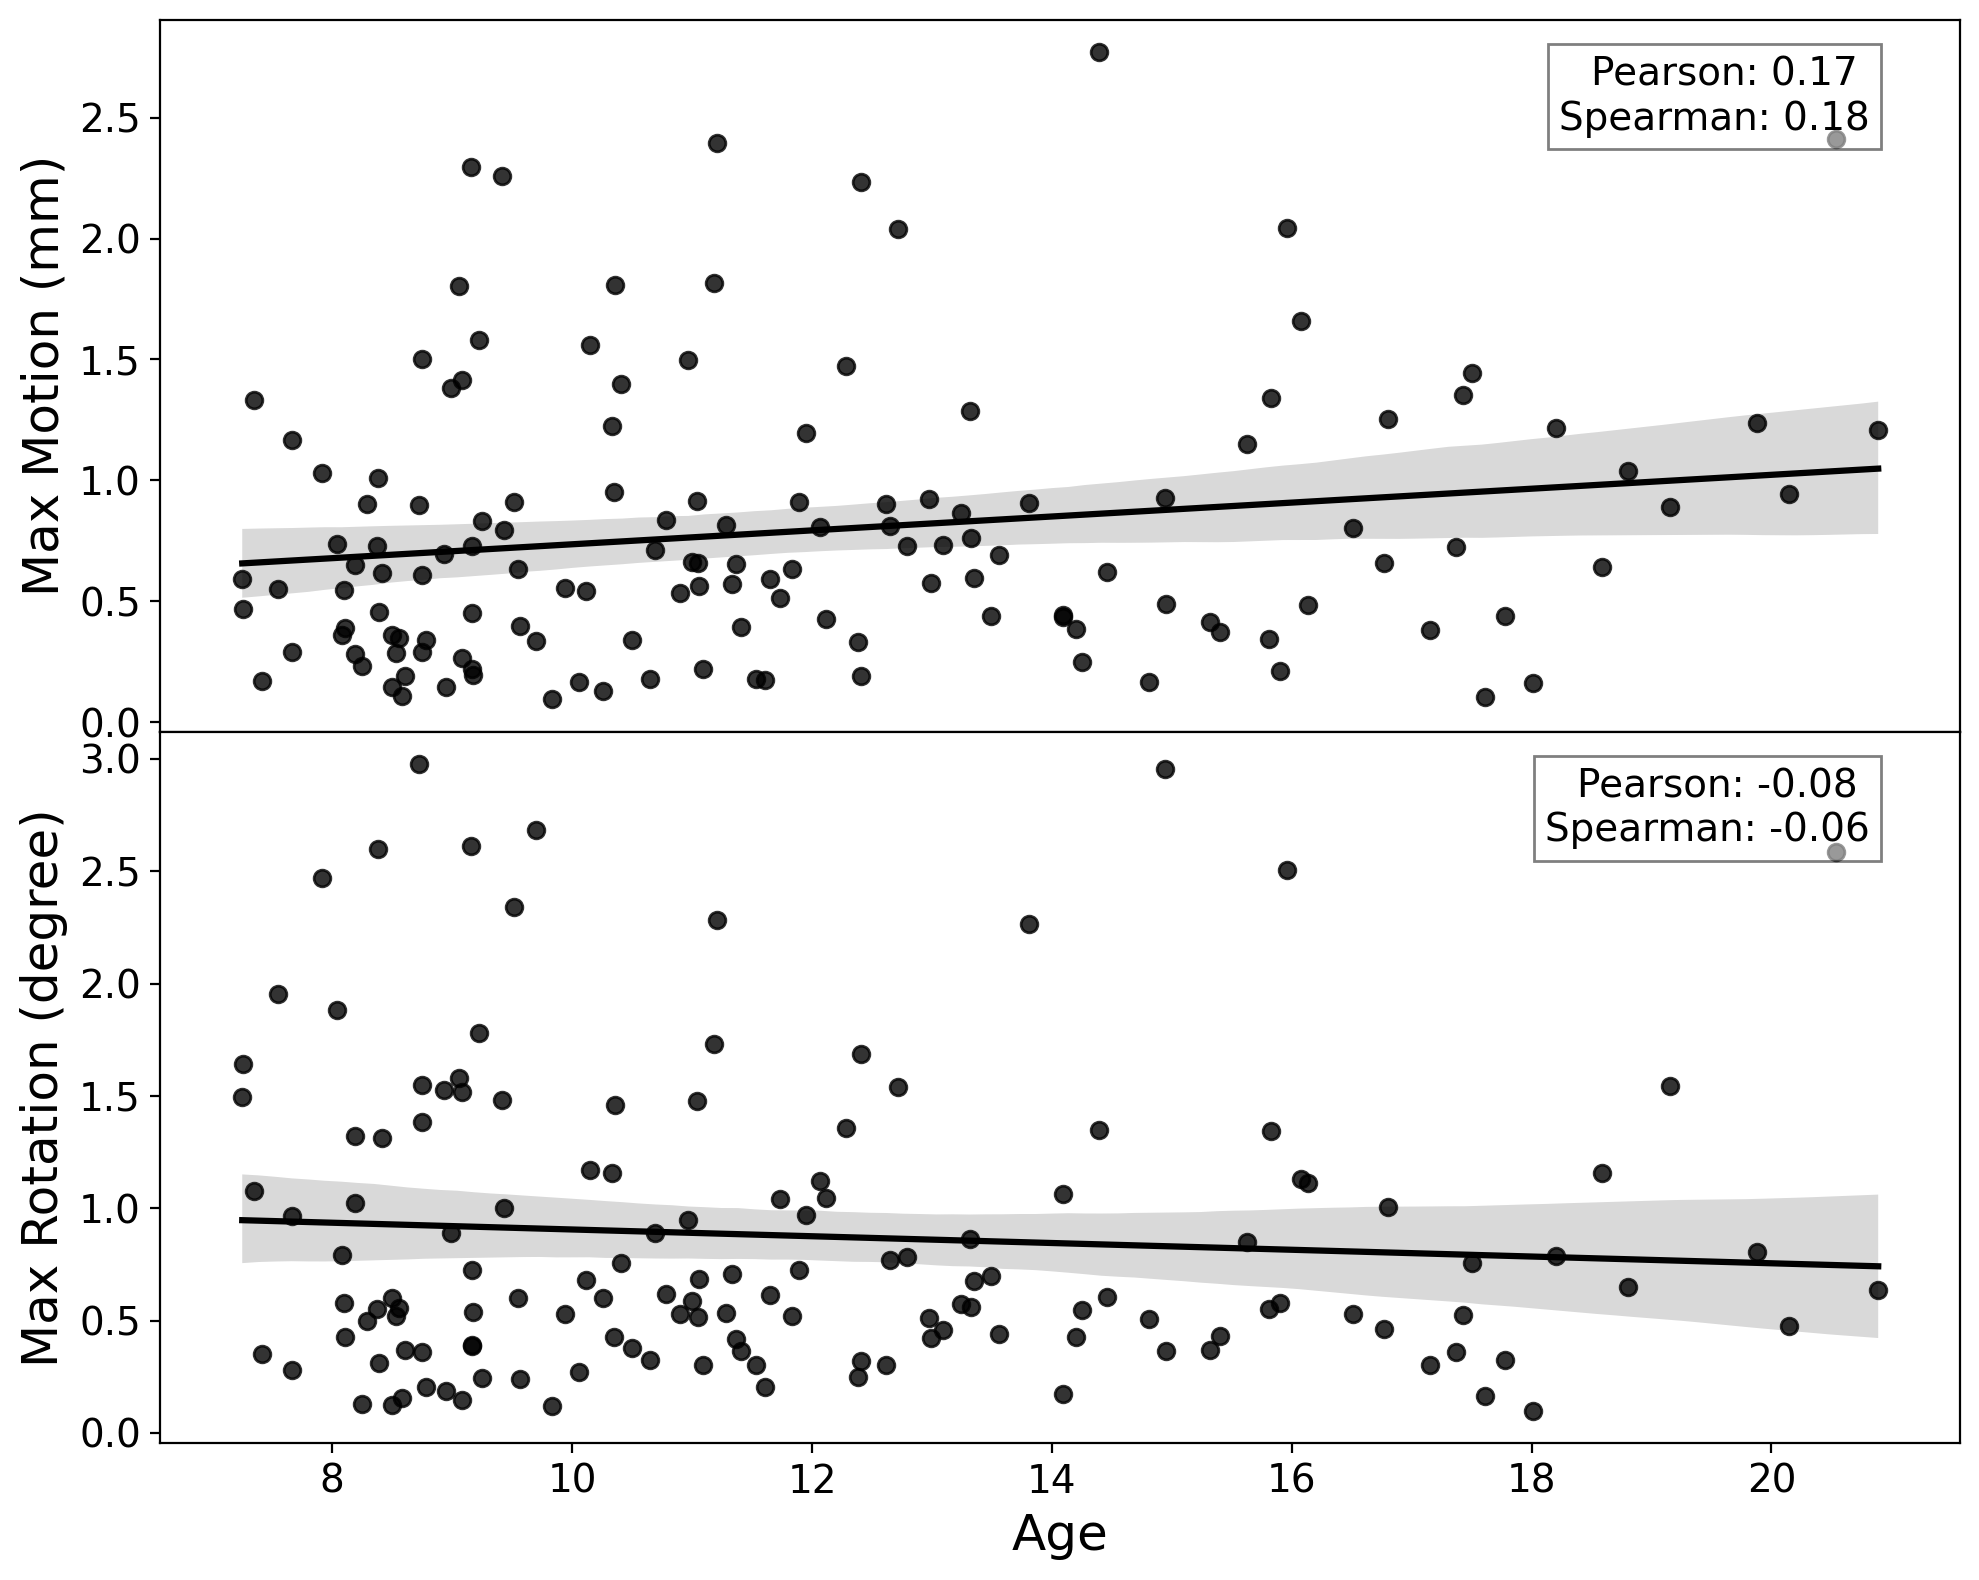

In [392]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

# Create a figure with two subplots sharing the x-axis and remove spacing between them
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), dpi=200, sharex=True, gridspec_kw={'hspace': 0})

# First plot
sns.regplot(data=df, y='Max Motion (mm)', x='Age', color='black', ax=ax1)
correlation_value = np.corrcoef([df['Age'].values, df['Max Motion (mm)'].values])[0, 1]
spearman = stats.spearmanr(df['Age'].values, df['Max Motion (mm)'].values).statistic
text = f'Pearson: {correlation_value:.2f} \nSpearman: {spearman:.2f}'
ax1.text(0.95, 0.95, text, ha='right', va='top', transform=ax1.transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'), size=14)
ax1.set_ylabel('Max Motion (mm)', fontsize=18)
ax1.label_outer()  # Only show bottom and left ticks and labels

# Second plot
sns.regplot(data=df, y=' Max Rotation (degree)', x='Age', color='black', ax=ax2)
correlation_value = np.corrcoef([df['Age'].values, df[' Max Rotation (degree)'].values])[0, 1]
spearman = stats.spearmanr(df['Age'].values, df[' Max Rotation (degree)'].values).statistic
text = f'Pearson: {correlation_value:.2f} \nSpearman: {spearman:.2f}'
ax2.text(0.95, 0.95, text, ha='right', va='top', transform=ax2.transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'), size=14)
ax2.set_xlabel('Age', fontsize=18)
ax2.set_ylabel('Max Rotation (degree)', fontsize=18)
ax2.label_outer()  # Only show bottom and left ticks and labels

# Increase the size of the x-axis ticks for both subplots
plt.xticks(fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)  # Increase tick size
ax2.tick_params(axis='both', which='major', labelsize=14)  # Increase tick size


# Ensure the plots are aligned and labels are only on the bottom plot
plt.tight_layout()
plt.show()

PearsonRResult(statistic=0.1733678703787827, pvalue=0.04051454382183008)


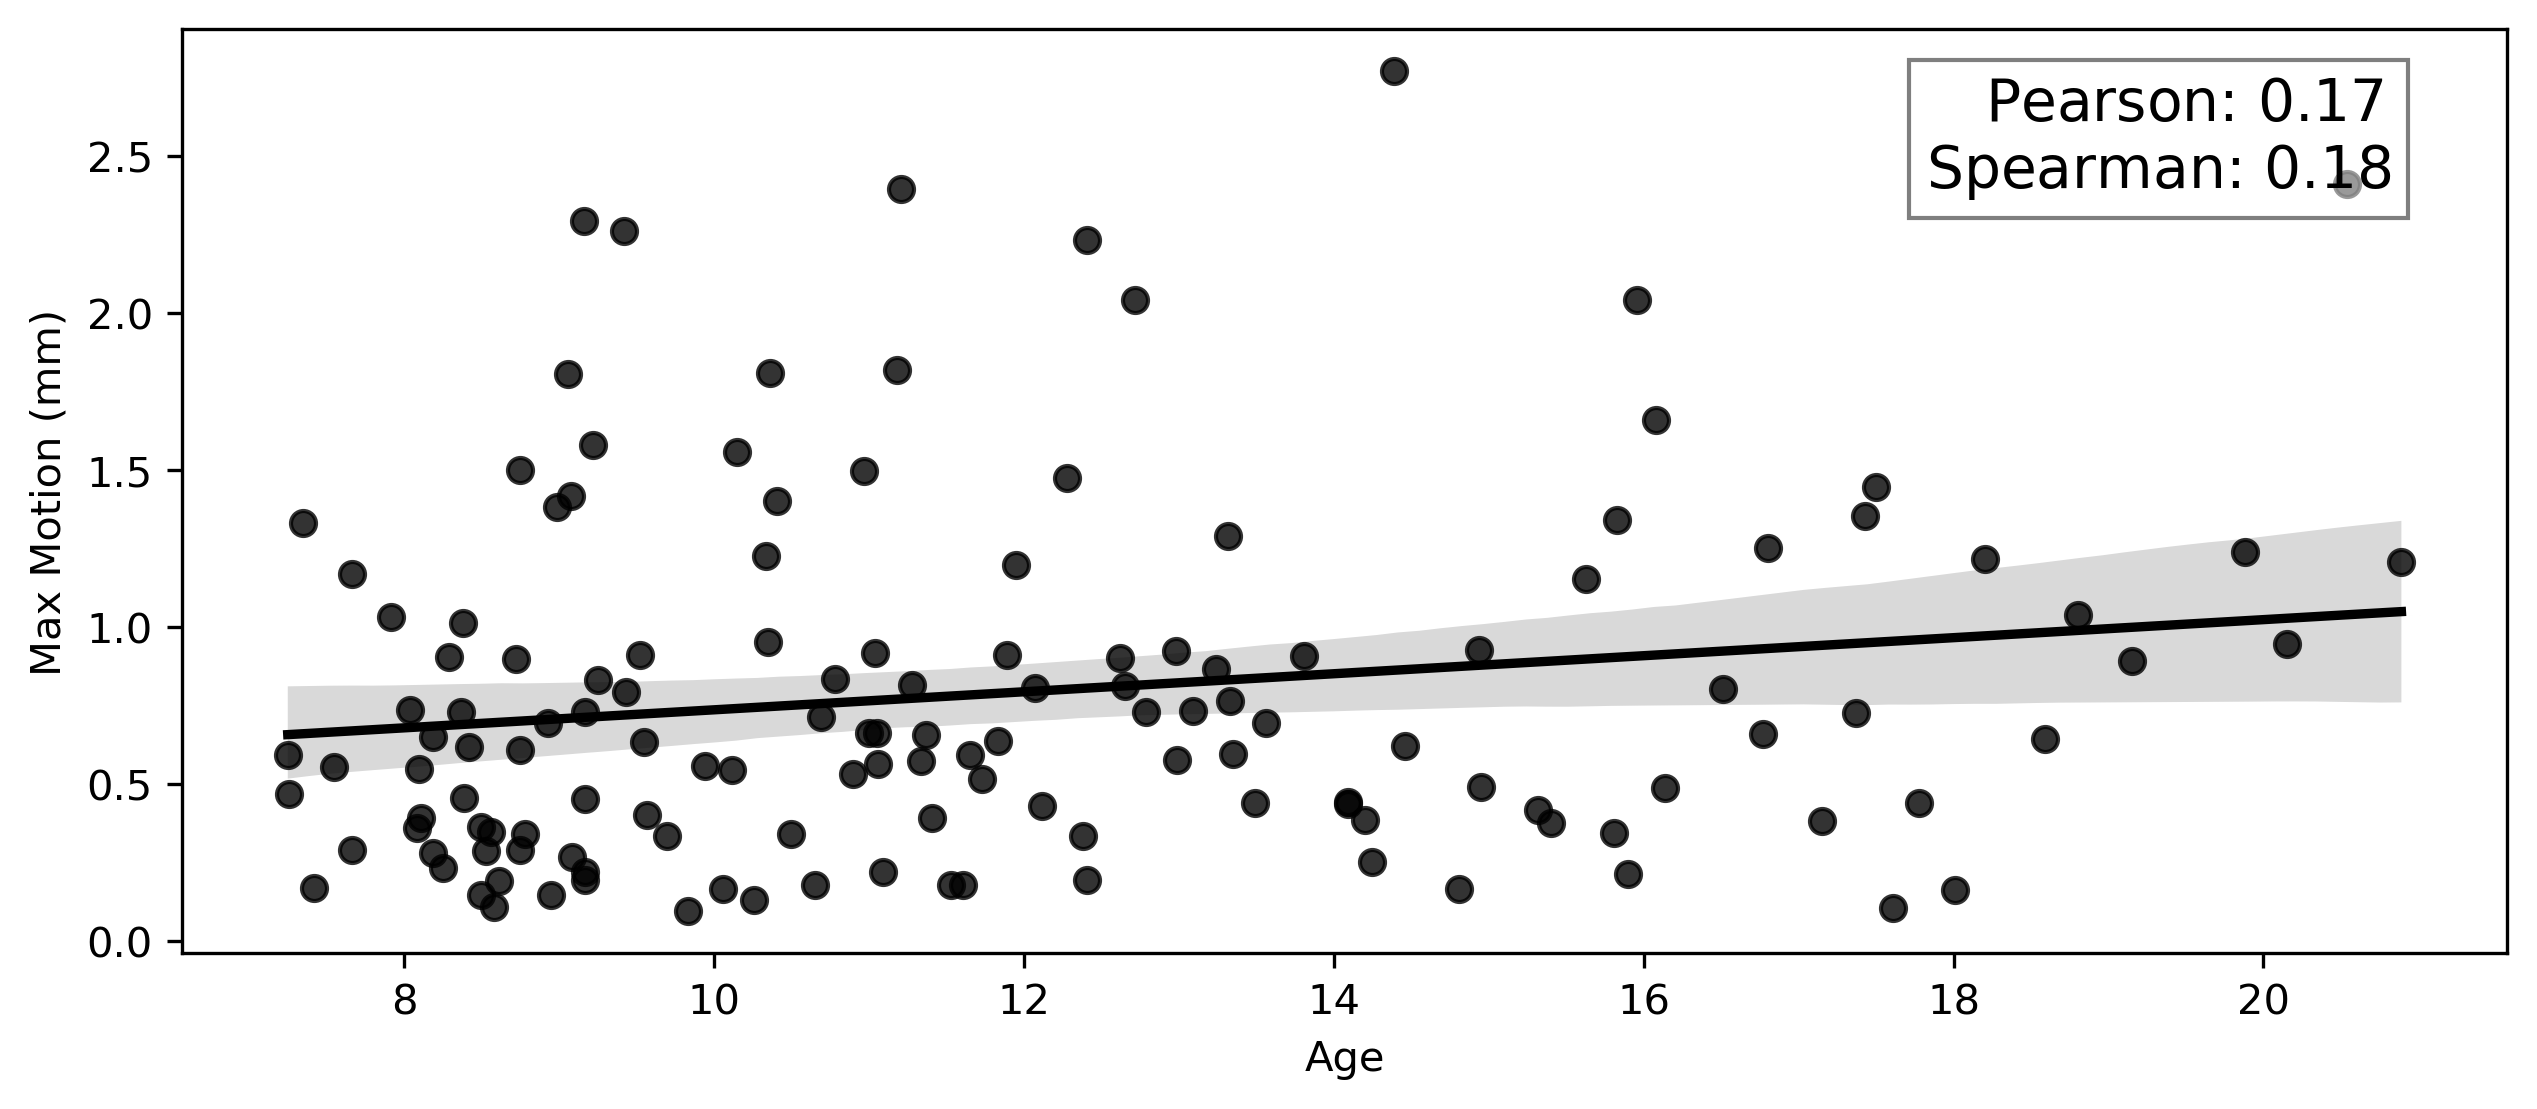

In [393]:
plt.figure(figsize=(10,4),dpi=300)
print(stats.pearsonr(df['Age'], df['Max Motion (mm)']))


sns.regplot(data=df, y='Max Motion (mm)', x='Age',color='black')

correlation_value = np.corrcoef([df['Age'].values, df['Max Motion (mm)'].values])[0,1]
spearman = stats.spearmanr(df['Age'].values, df['Max Motion (mm)'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{}}$ \nSpearman: {spearman:.2f}$^{{}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),size=14)

#plt.colorbar(label='Age')
plt.xlabel(r'Age')
plt.ylabel(r'Max Motion (mm)')
#plt.xlim(0,1.5)
#plt.ylim(1.8,2.5)

plt.show()

PearsonRResult(statistic=-0.07692497555209767, pvalue=0.36633071847375087)


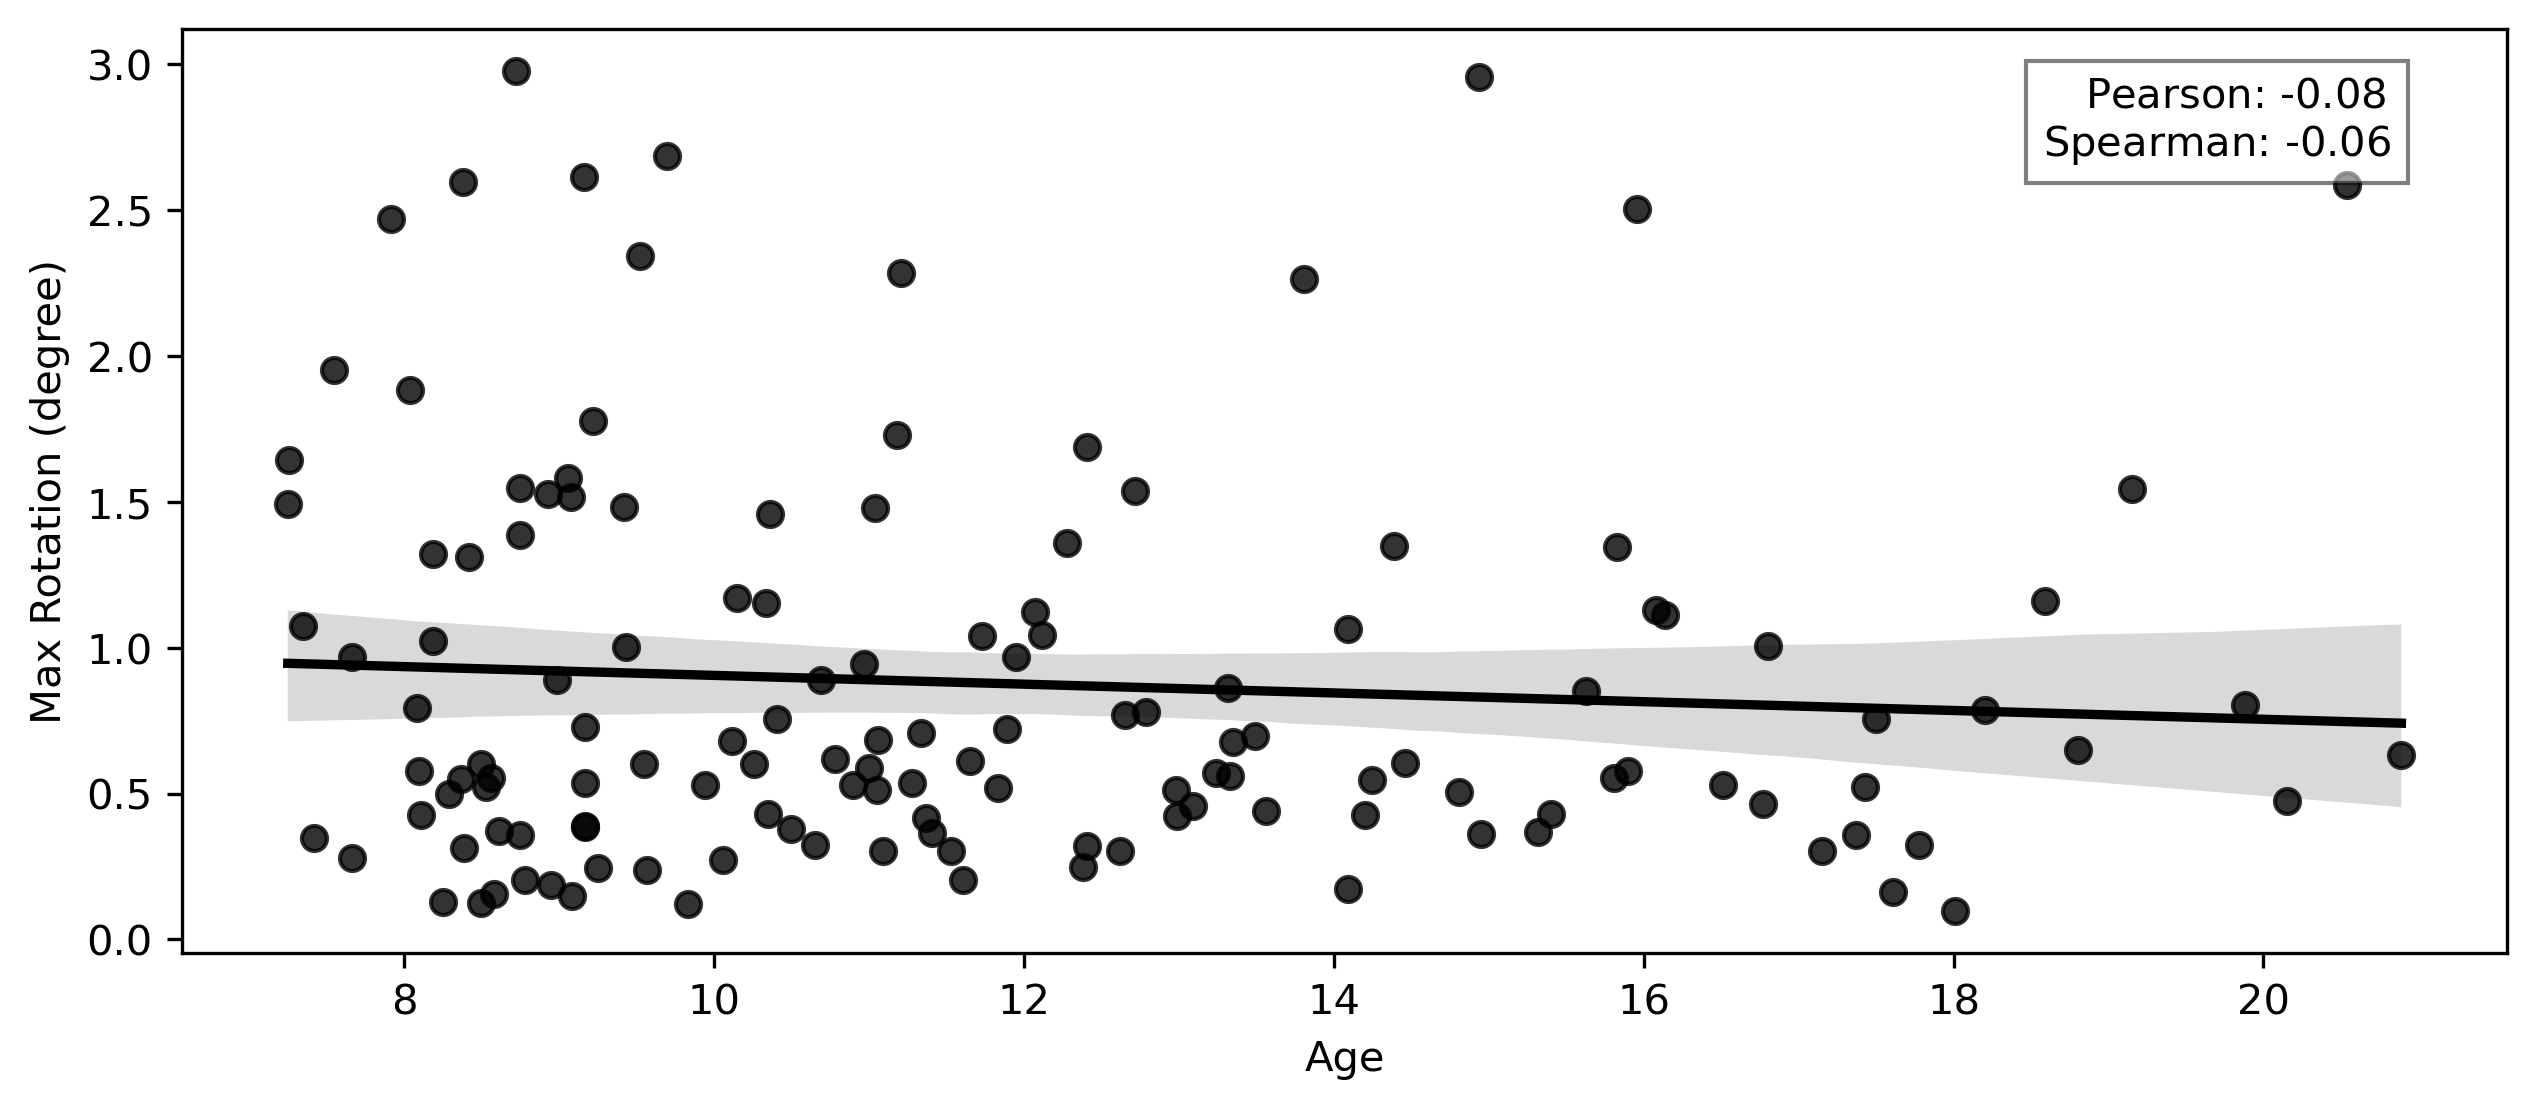

In [394]:
plt.figure(figsize=(10,4),dpi=300)
print(stats.pearsonr(df['Age'], df[' Max Rotation (degree)']))


sns.regplot(data=df, y=' Max Rotation (degree)', x='Age',color='black')

correlation_value = np.corrcoef([df['Age'].values, df[' Max Rotation (degree)'].values])[0,1]
spearman = stats.spearmanr(df['Age'].values, df[' Max Rotation (degree)'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{}}$ \nSpearman: {spearman:.2f}$^{{}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

#plt.colorbar(label='Age')
plt.xlabel(r'Age')
plt.ylabel(r'Max Rotation (degree)')
#plt.xlim(0,1.5)
#plt.ylim(1.8,2.5)

plt.show()

PearsonRResult(statistic=0.04072022567499688, pvalue=0.632873153240372)


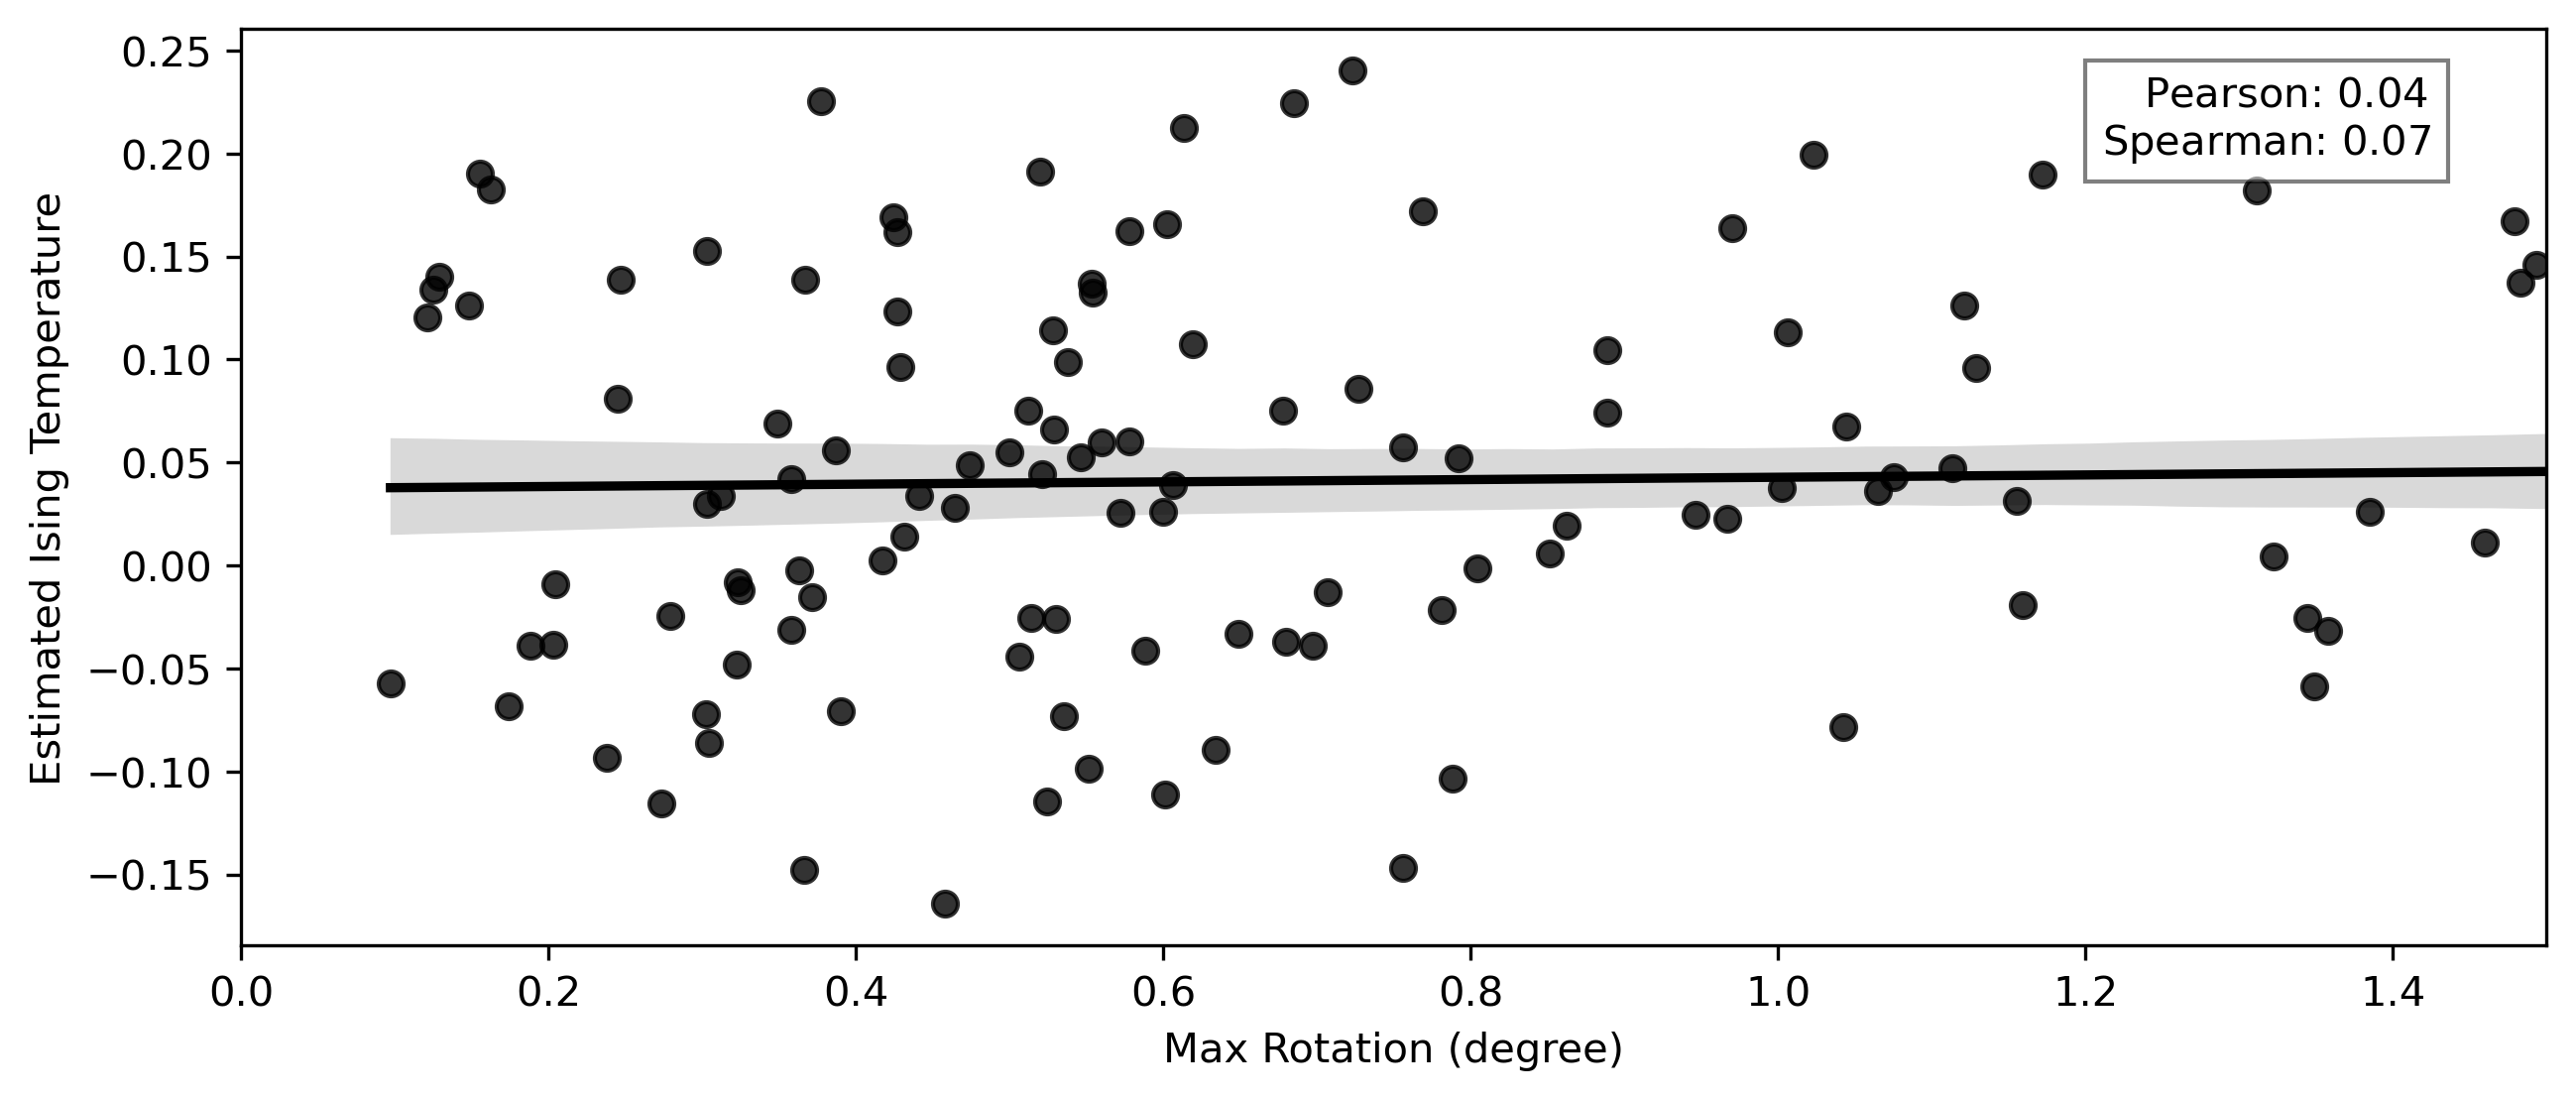

In [395]:
plt.figure(figsize=(10,4),dpi=300)
print(stats.pearsonr(df['Temperature'], df[' Max Rotation (degree)']))


sns.regplot(data=df, x=' Max Rotation (degree)', y='Temperature',color='black')

correlation_value = np.corrcoef([df['Temperature'].values, df[' Max Rotation (degree)'].values])[0,1]
spearman = stats.spearmanr(df['Temperature'].values, df[' Max Rotation (degree)'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{}}$ \nSpearman: {spearman:.2f}$^{{}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

#plt.colorbar(label='Age')
plt.ylabel(r'Estimated Ising Temperature')
plt.xlabel(r'Max Rotation (degree)')
plt.xlim(0,1.5)
#plt.ylim(1.8,2.5)

plt.show()

PearsonRResult(statistic=-0.052921138626032385, pvalue=0.5346043455270366)


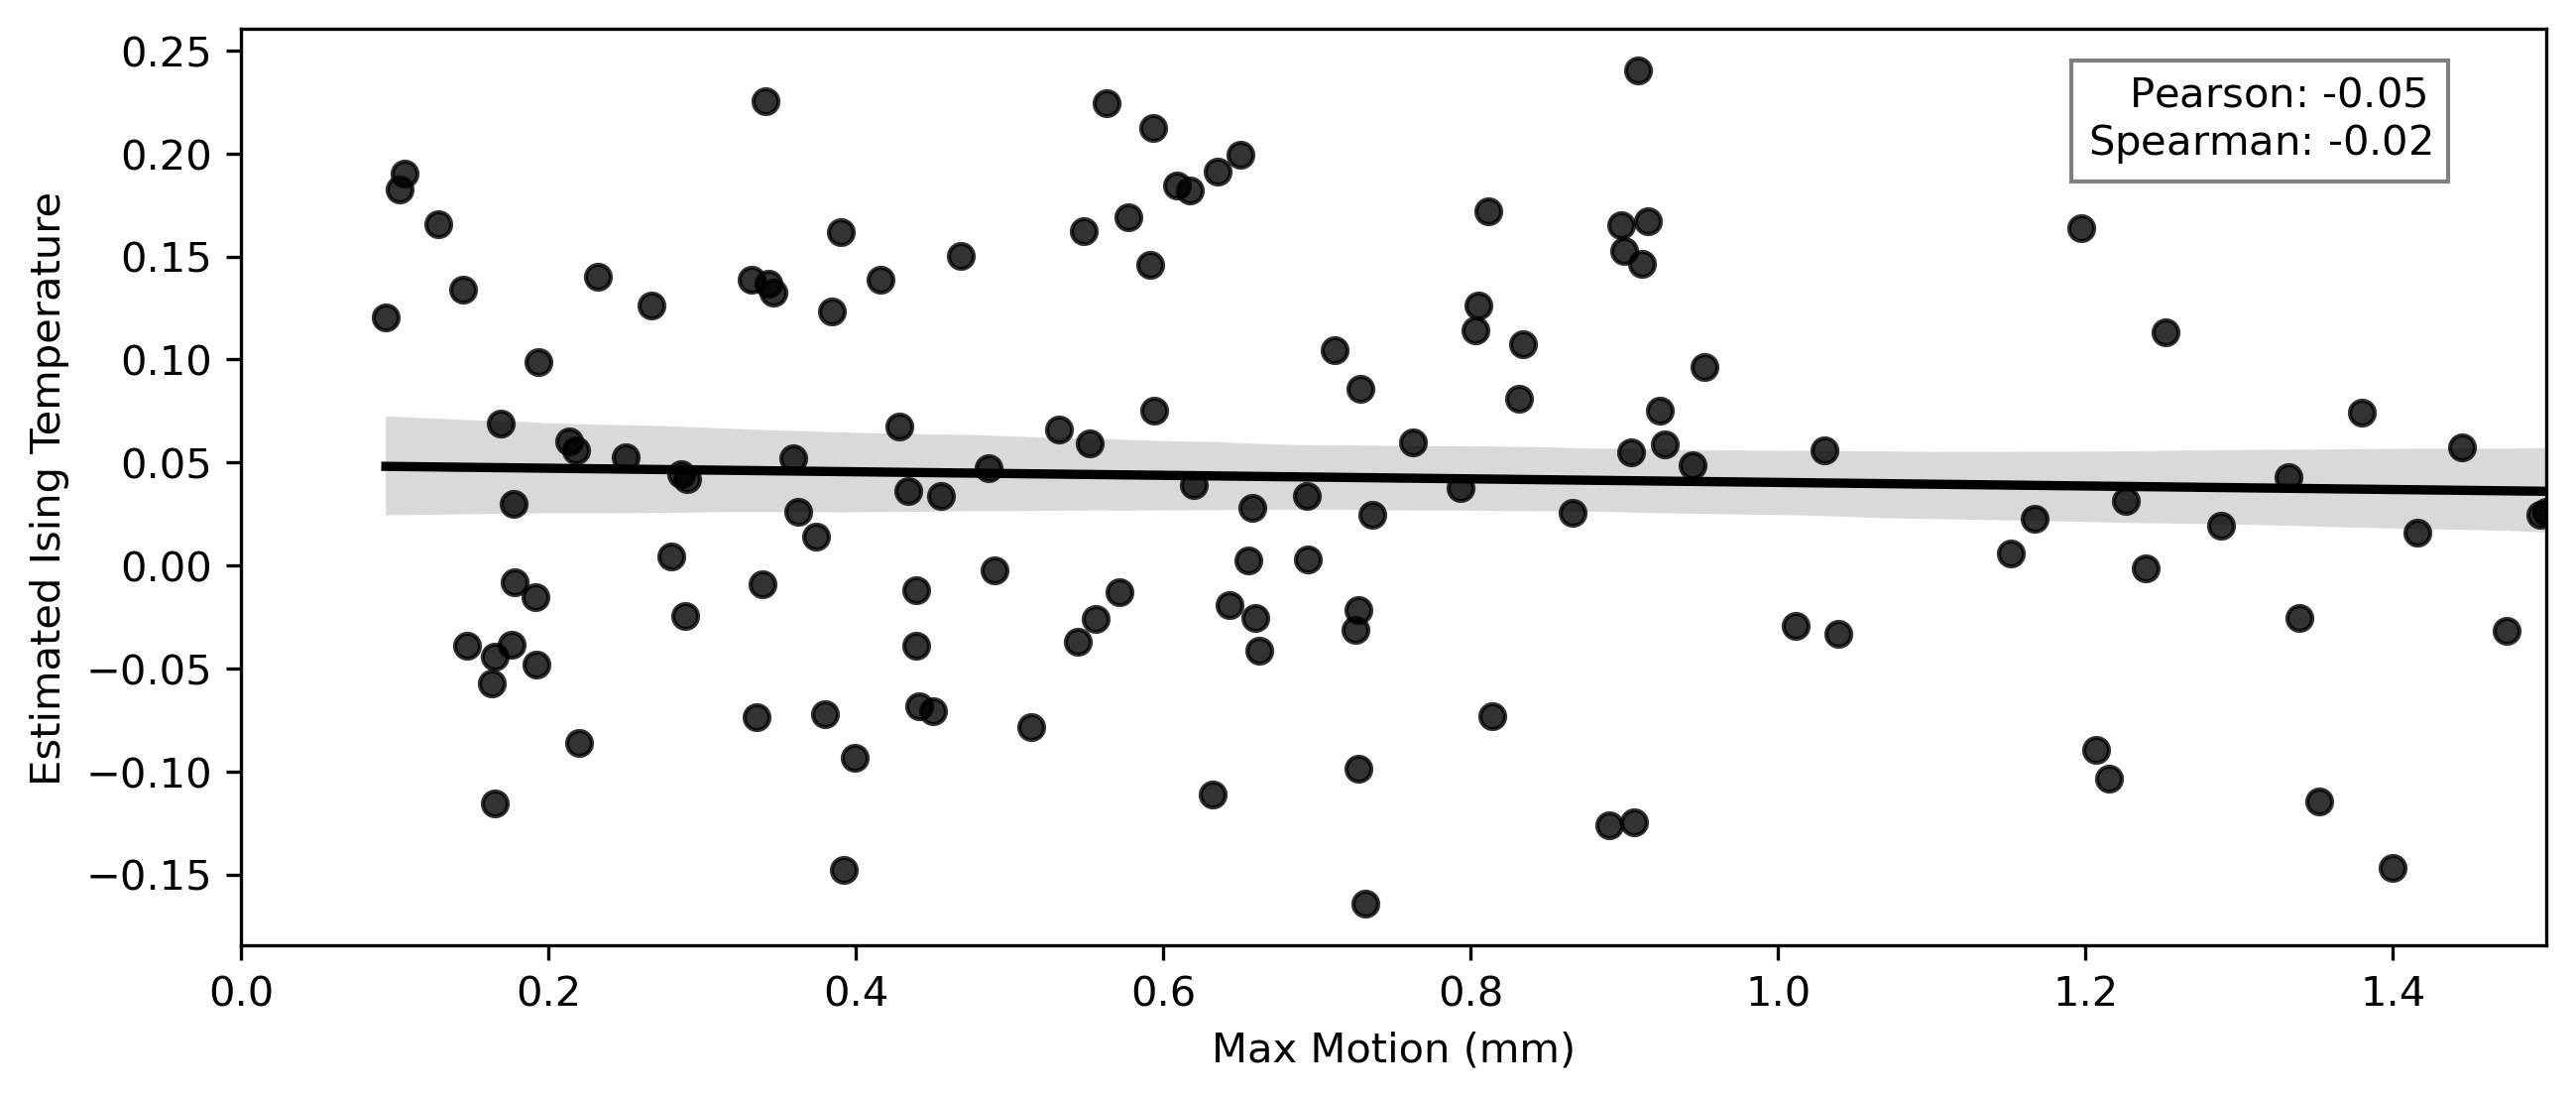

In [396]:
plt.figure(figsize=(10,4),dpi=300)
print(stats.pearsonr(df['Temperature'], df['Max Motion (mm)']))


sns.regplot(data=df, x='Max Motion (mm)', y='Temperature',color='black')

correlation_value = np.corrcoef([df['Temperature'].values, df['Max Motion (mm)'].values])[0,1]
spearman = stats.spearmanr(df['Temperature'].values, df['Max Motion (mm)'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{}}$ \nSpearman: {spearman:.2f}$^{{}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

#plt.colorbar(label='Age')
plt.ylabel(r'Estimated Ising Temperature')
plt.xlabel(r'Max Motion (mm)')
plt.xlim(0,1.5)
#plt.ylim(1.8,2.5)

plt.show()

<Axes: xlabel='Temperature', ylabel='Max Motion (mm)'>

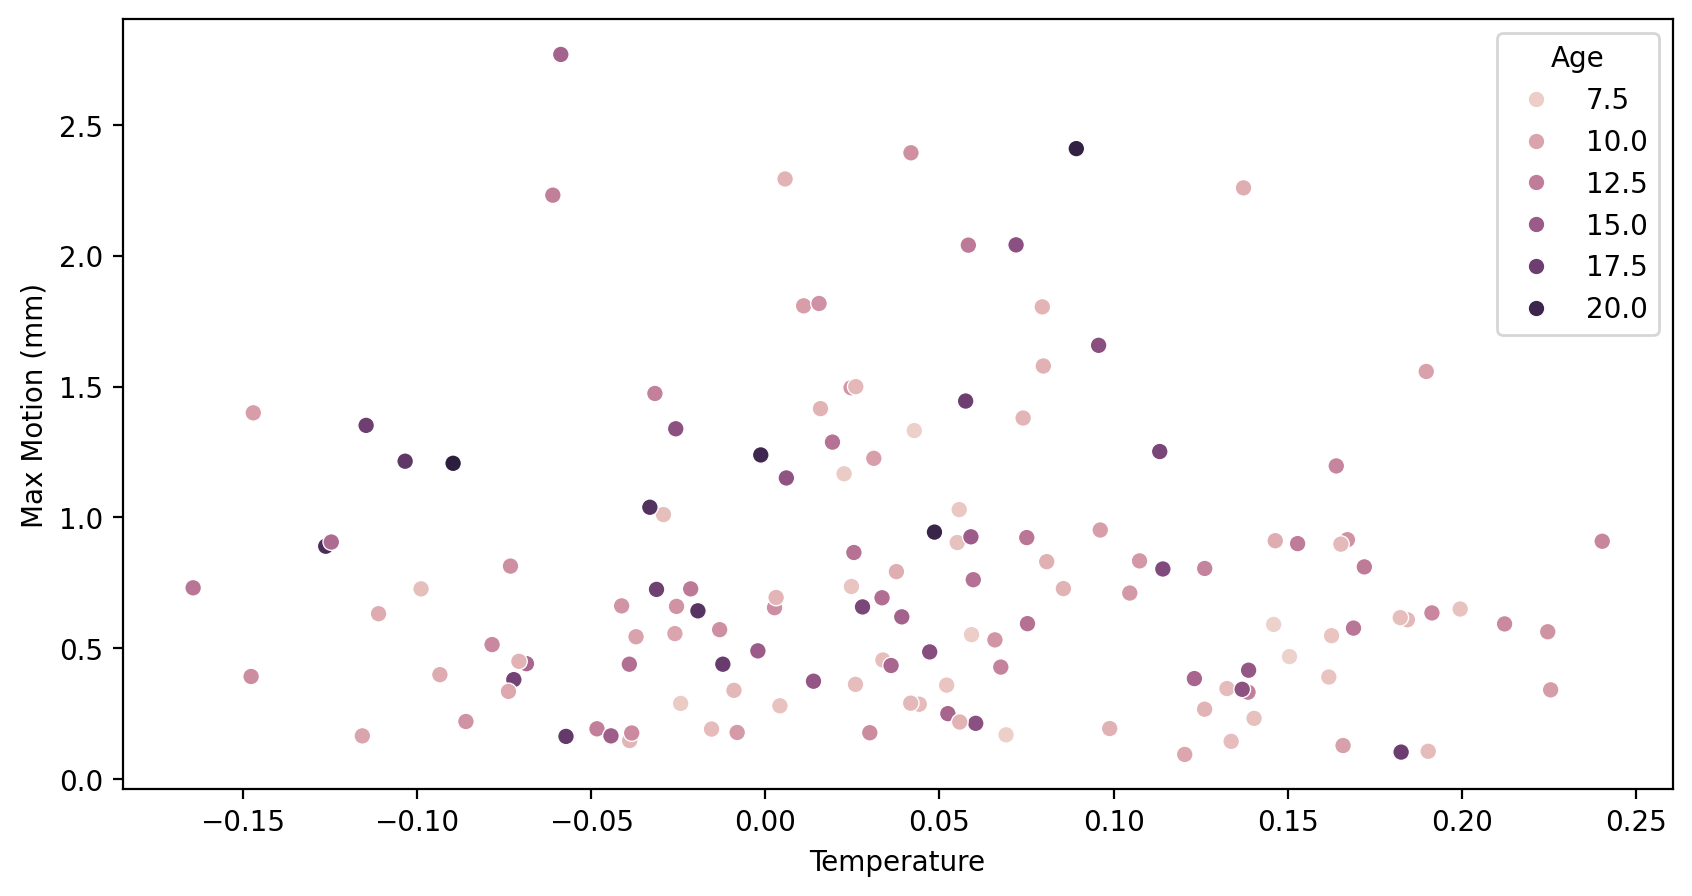

In [397]:
plt.figure(figsize=(10,5), dpi=200)
#sns.jointplot(data=df, x='Temperature', y='Max Motion (mm)', hue='Age')
#plt.xlim(2,2.2)
#plt.ylim(0,5)
sns.scatterplot(data=df, x='Temperature', y='Max Motion (mm)', hue='Age')

In [398]:
print('Pearson Temperature and Age = {}'.format(np.corrcoef([df['Temperature'], df['Age']])[0,1]))
print('Spearman Temperature and Age = {}'.format(stats.spearmanr(df['Age'].values, df['Temperature'].values).statistic))


Pearson Temperature and Age = -0.21516570845061359
Spearman Temperature and Age = -0.2088634790891572


In [399]:
print('Pearson Temperature and Max Motion = {}'.format(np.corrcoef([df['Temperature'], df['Max Motion (mm)']])[0,1]))
print('Spearman Temperature and Max Motion = {}'.format(stats.spearmanr(df['Temperature'].values, df['Max Motion (mm)'].values).statistic))


Pearson Temperature and Max Motion = -0.05292113862603235
Spearman Temperature and Max Motion = -0.02414562598346499


In [400]:
print('Pearson Temperature and Max Rotation = {}'.format(np.corrcoef([df['Temperature'], df[' Max Rotation (degree)']])[0,1]))
print('Spearman Temperature and Rotation = {}'.format(stats.spearmanr(df['Temperature'].values, df[' Max Rotation (degree)'].values).statistic))

Pearson Temperature and Max Rotation = 0.04072022567499686
Spearman Temperature and Rotation = 0.07260767930671186


In [401]:
print('Pearson Age and Max Motion = {}'.format(np.corrcoef([df['Age'], df[' Max Rotation (degree)']])[0,1]))
print('Spearman Age and Max Motion = {}'.format(stats.spearmanr(df['Age'].values, df[' Max Rotation (degree)'].values).statistic))

Pearson Age and Max Motion = -0.07692497555209758
Spearman Age and Max Motion = -0.061795252795104484


In [402]:
X = df[['Max Motion (mm)',' Max Rotation (degree)', 'Age']] # 'DX'
y = df['Temperature']

# X = df[['Max Motion (mm)',' Max Rotation (degree)', 'Temperature']] # 'DX'
# y = df['Age']


X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
y = (y - y.min(axis=0)) / (y.max(axis=0) - y.min(axis=0))

In [403]:
import statsmodels.api as sm

X = sm.add_constant(X)
mod = sm.OLS(y, X).fit()
pred = mod.predict(X)


In [404]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2.305
Date:                Tue, 19 Nov 2024   Prob (F-statistic):             0.0797
Time:                        14:51:57   Log-Likelihood:                 13.504
No. Observations:                 140   AIC:                            -19.01
Df Residuals:                     136   BIC:                            -7.242
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.5718      0.040     14.135      0.000       0.492       0.652
Max Motion (mm)           -0.0533      0.115     -0.462      0.645      -0.281       0.175
 Max Rotation (degree)     0.0531      0.104      0.511      0.610      -0.152       0.259
Age                       -0.1841      0.079     -2.323      0.022      -0.341      -0.027
==============================================================================
Omnibus:                        3.481   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                2.142
Skew:                          -0.001   Prob(JB):                        0.343
Kurtosis:                       2.394   Cond. No.                         8.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [405]:
stats.pearsonr(df['Age'].values, df['Temperature'].values)

PearsonRResult(statistic=-0.21516570845061356, pvalue=0.0106791478870575)

In [406]:
stats.spearmanr(df['Age'].values, df['Temperature'].values)

SignificanceResult(statistic=-0.2088634790891572, pvalue=0.013266761744094127)

In [407]:
stats.spearmanr(df['Age'].values, df['Temperature'].values).statistic

-0.2088634790891572

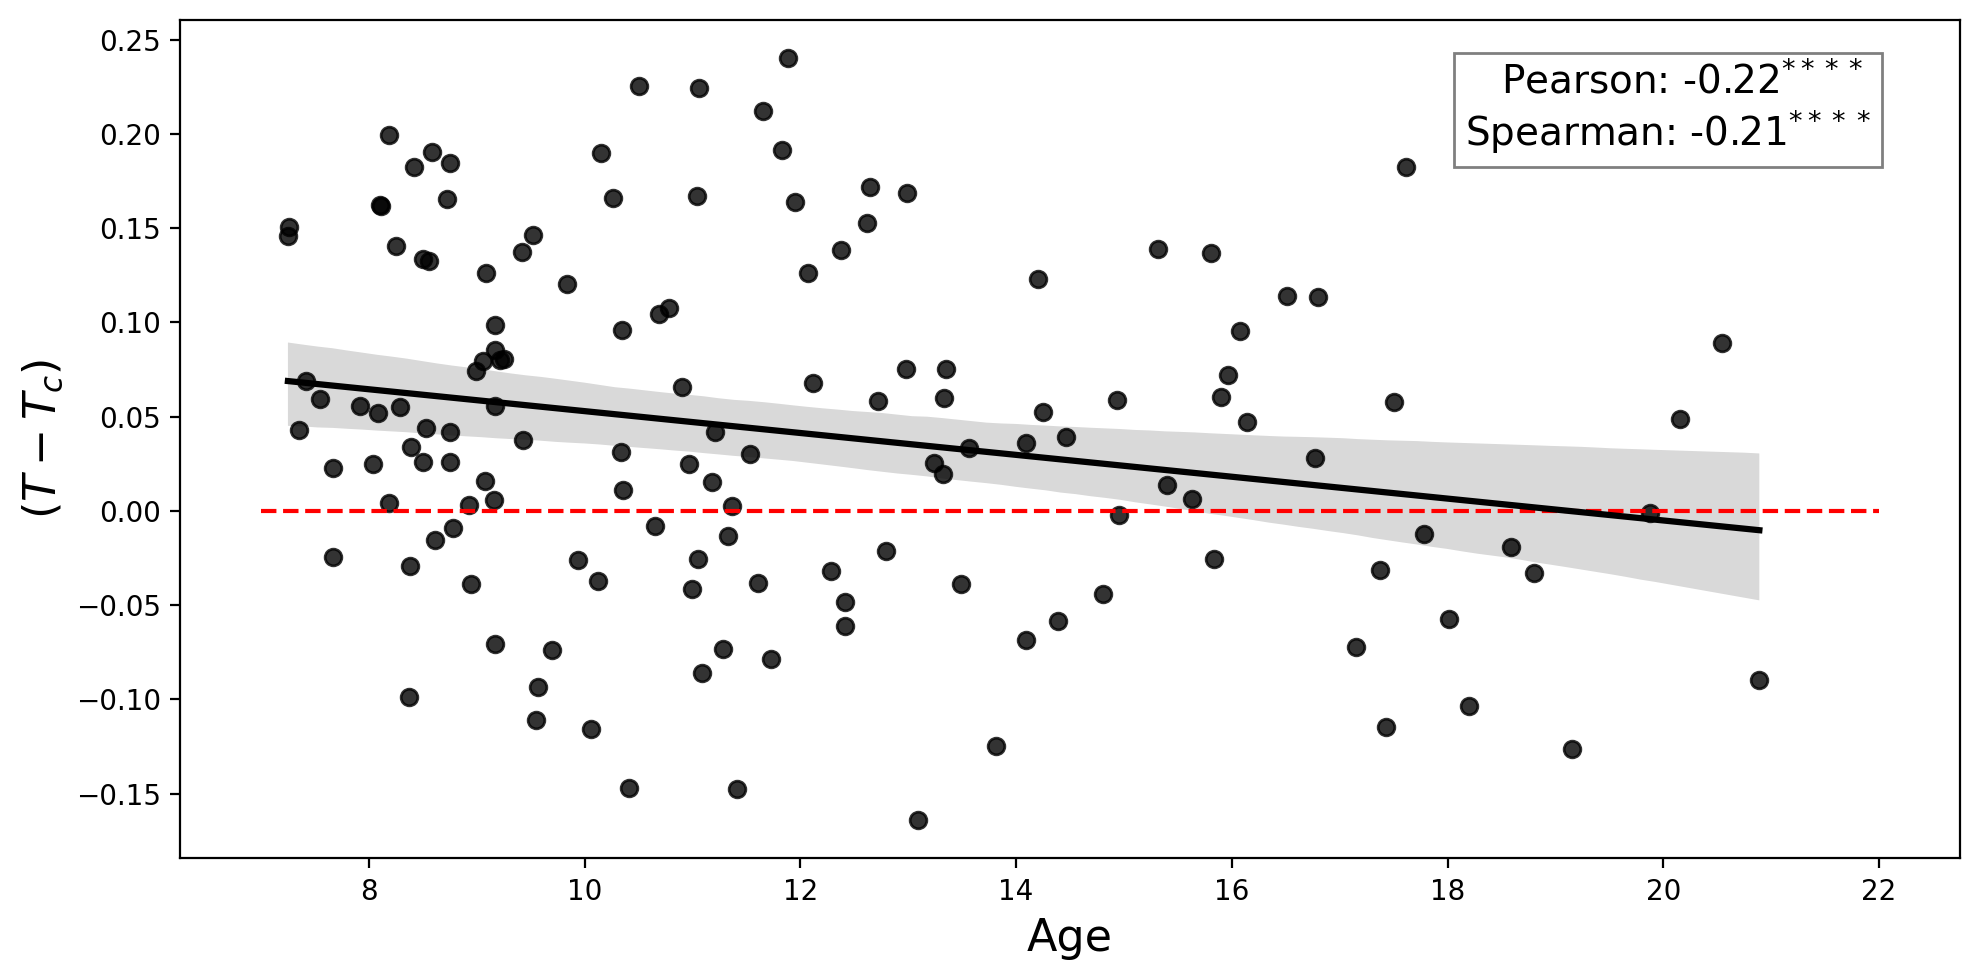

In [ ]:
from scipy import stats

plt.figure(figsize=(10,5),dpi=200)
plt.hlines(0, xmin=7,xmax=22, colors='red', linestyles='dashed')
sns.regplot(data=df, x='Age', y='Temperature',color='black')

correlation_value = np.corrcoef([df['Age'].values, df['Temperature'].values])[0,1]
spearman = stats.spearmanr(df['Age'].values, df['Temperature'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{**}}$ \nSpearman: {spearman:.2f}$^{{**}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),size=14)

#plt.ylim(-0.2, 0.3)
plt.ylabel(r'$(T - T_c)$', size=16)
plt.xlabel(r'Age', size=16)
plt.tight_layout()
plt.show()

/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_64142/399419375.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Age Group', y='Dist_Temperature', data=df, palette='viridis_r')


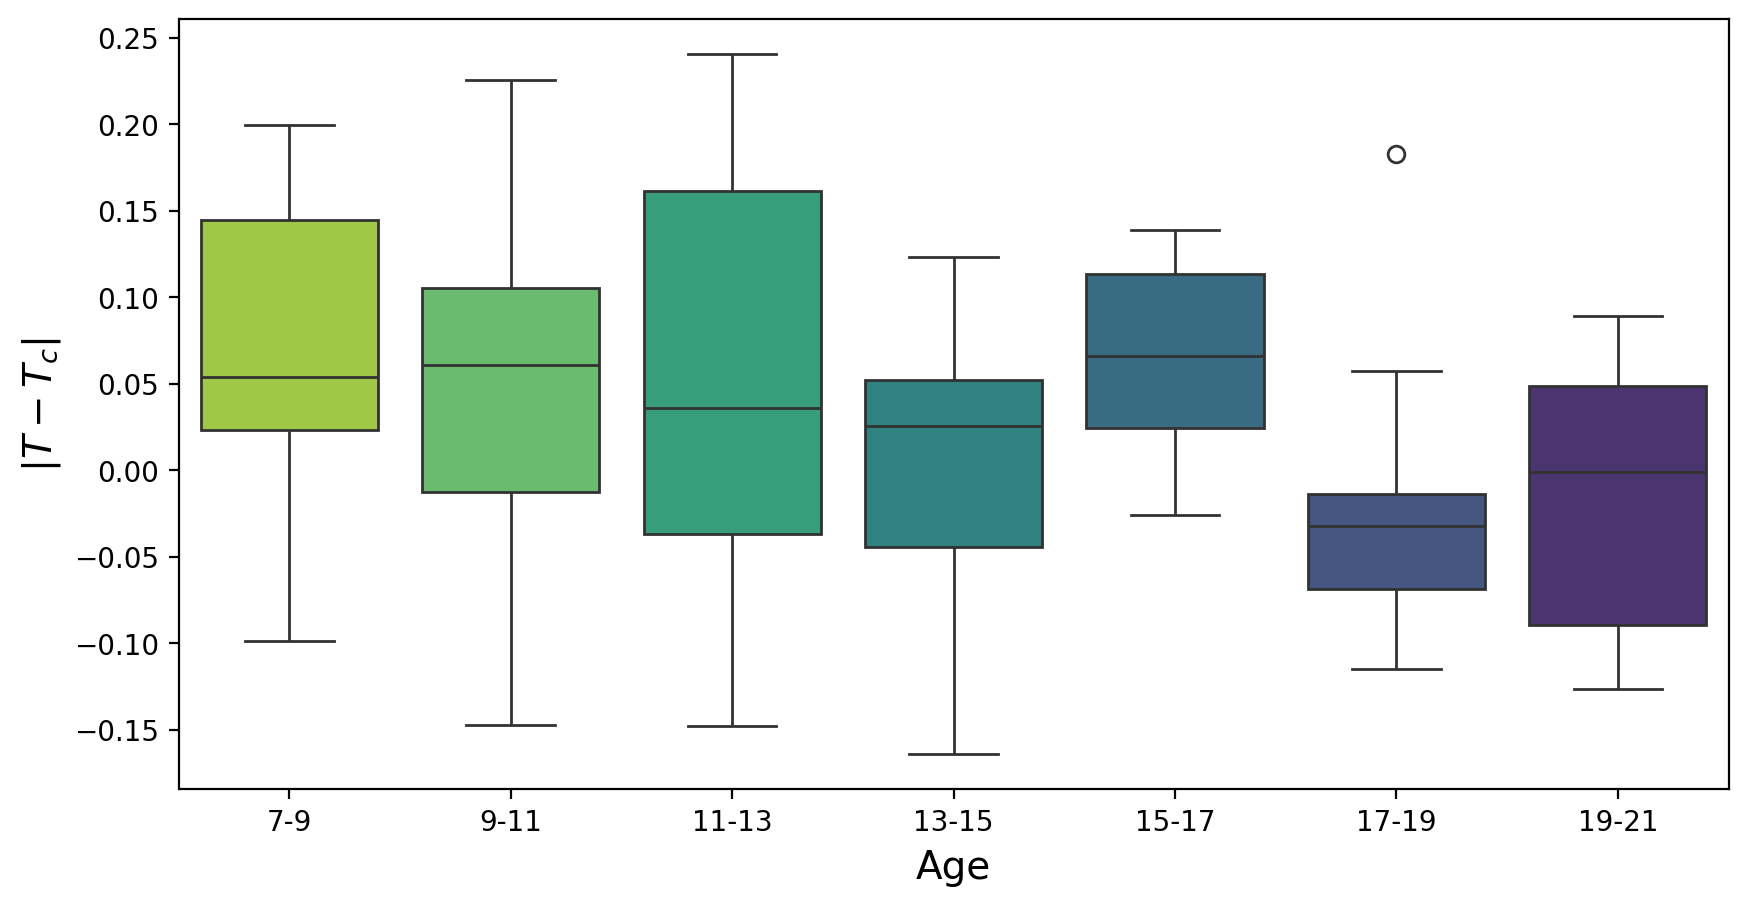

Comparison between 7-9 and 9-11 - Statistic: 1.2028648174637397, P-value: 4.907796263485402, Significant: False
Comparison between 7-9 and 11-13 - Statistic: 0.7013094858655474, P-value: 10.211152209775078, Significant: False
Comparison between 7-9 and 13-15 - Statistic: 3.0270414455905224, P-value: 0.09933324059413615, Significant: False
Comparison between 7-9 and 15-17 - Statistic: 0.1422502977937378, P-value: 18.64586775814429, Significant: False
Comparison between 7-9 and 17-19 - Statistic: 2.951288975567231, P-value: 0.2261237313756047, Significant: False
Comparison between 7-9 and 19-21 - Statistic: 1.9973519749770958, P-value: 2.1690956081751307, Significant: False
Comparison between 9-11 and 11-13 - Statistic: -0.33717286648781075, P-value: 15.48162611311559, Significant: False
Comparison between 9-11 and 13-15 - Statistic: 1.7422611908457495, P-value: 1.8742916399736538, Significant: False
Comparison between 9-11 and 15-17 - Statistic: -0.9961288007213585, P-value: 6.850217260

In [409]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import itertools

# Assuming 'df' is your DataFrame and it has columns 'Age' and 'Temperature'

# Define the age bins and their labels
bins = [7, 9, 11, 13, 15, 17, 19, 21]
labels = ['7-9', '9-11', '11-13', '13-15', '15-17', '17-19', '19-21']

# Create a new column 'Age Group' with the binned ages
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
df['Dist_Temperature'] = (df['Temperature'])

# Plot the box plot
plt.figure(figsize=(10, 5), dpi=200)
sns.boxplot(x='Age Group', y='Dist_Temperature', data=df, palette='viridis_r')
plt.ylabel(r'$|T - T_c|$', size=14)
plt.xlabel('Age', size=14)
plt.show()

# Calculate pairwise t-tests between all groups
combinations = list(itertools.combinations(labels, 2))
p_values = []
results = []

for combo in combinations:
    group1 = df[df['Age Group'] == combo[0]]['Dist_Temperature']
    group2 = df[df['Age Group'] == combo[1]]['Dist_Temperature']
    stat, p = ttest_ind(group1, group2, equal_var=False)  # Welch's t-test
    p_values.append(p)
    results.append((combo[0], combo[1], stat, p))

# Adjust for multiple comparisons using Bonferroni correction
alpha = 0.05
p_adjusted = [p * len(p_values) for p in p_values]  # Bonferroni correction
adjusted_results = [(result[0], result[1], result[2], p, p < alpha / len(combinations)) for result, p in zip(results, p_adjusted)]

# Print results
for res in adjusted_results:
    print(f"Comparison between {res[0]} and {res[1]} - Statistic: {res[2]}, P-value: {res[3]}, Significant: {res[4]}")


/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_64142/521314957.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Age Group', y='Dist_Temperature', data=df, palette='viridis_r')


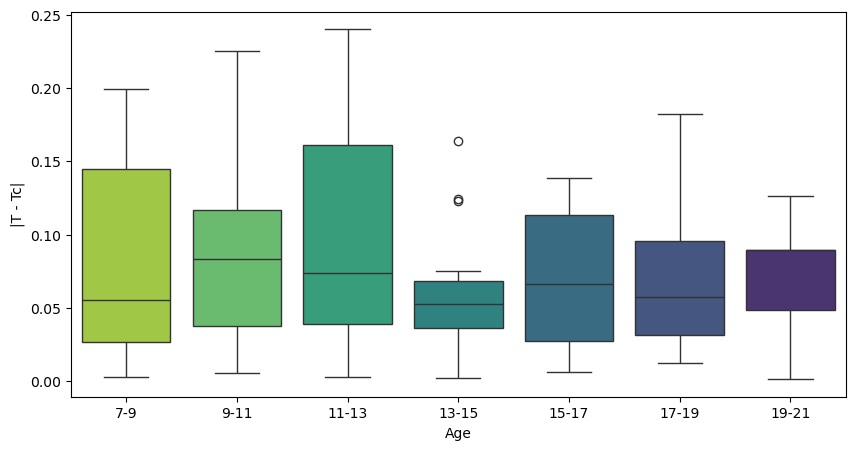

ANOVA test result - F Statistic: 0.9348697178241768, P-value: 0.4723088492606764
No significant differences found among the groups.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Assuming you have already loaded your DataFrame 'df' and it has columns 'Age' and 'Temperature'

# Define the age bins and their labels
bins = [7, 9, 11, 13, 15, 17, 19, 21]
labels = ['7-9', '9-11', '11-13', '13-15', '15-17', '17-19', '19-21']

# Create a new column 'Age Group' with the binned ages
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
df['Dist_Temperature'] = (df['Temperature'])

# Drop any rows where 'Age Group' or 'Dist_Temperature' is NaN
df.dropna(subset=['Age Group', 'Dist_Temperature'], inplace=True)

# Plot the box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x='Age Group', y='Dist_Temperature', data=df, palette='viridis_r')
plt.ylabel('|T - Tc|')
plt.xlabel('Age')
plt.show()

# Perform ANOVA test
anova_result = f_oneway(*[df[df['Age Group'] == group]['Dist_Temperature'] for group in labels])

print(f"ANOVA test result - F Statistic: {anova_result.statistic}, P-value: {anova_result.pvalue}")

# If the ANOVA test is significant, perform Tukey's HSD test
if anova_result.pvalue < 0.05:
    print("Significant differences were found, proceeding with Tukey's HSD test...")
    tukey = pairwise_tukeyhsd(endog=df['Dist_Temperature'], groups=df['Age Group'], alpha=0.05)
    print(tukey)
else:
    print("No significant differences found among the groups.")

In [411]:
print('Age Groups percentage', df['Age Group'].value_counts(normalize=True) * 100)


Age Groups percentage Age Group
7-9      24.285714
9-11     22.857143
11-13    21.428571
13-15    12.142857
15-17     8.571429
17-19     7.142857
19-21     3.571429
Name: proportion, dtype: float64


/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_64142/823079007.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Documents/data/Thesis/adhd_dataset_gordon.csv')
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_64142/823079007.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_

(292, 7)


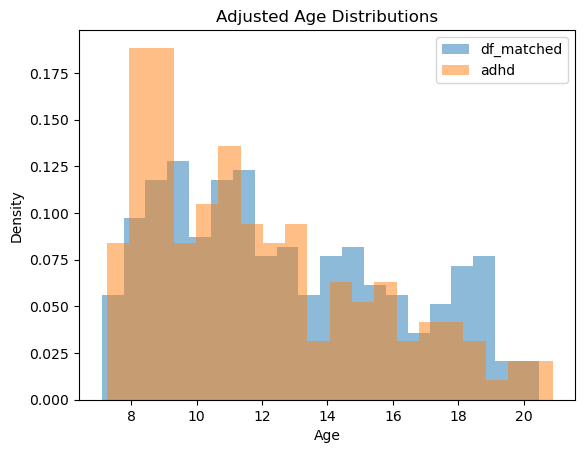

In [660]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd

df = adhd_ingestion(dx=0, max_m=3)
adhd = adhd_ingestion(dx=1, max_m=3)
adhd = adhd[adhd.Age < 21]
df = df[df.Age < 21]



# # Ensure ages are sorted for efficient matching
# adhd_sorted = adhd[['Age']].sort_values(by='Age').reset_index(drop=True)
# df_sorted = df[['Age']].sort_values(by='Age').reset_index()

# # Use Nearest Neighbors to match ages in df to adhd
# nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(adhd_sorted)
# distances, indices = nn.kneighbors(df_sorted[['Age']])

# # Identify rows in df that have a match within a small threshold
# threshold = 0.04  # Adjust based on tolerance
# df_sorted['match'] = distances.flatten() <= threshold

# # Keep only rows with matches
# df_matched = df_sorted[df_sorted['match']].reset_index(drop=True)

# # Optional: Merge back to original dataframe
# df = df.loc[df_matched['index']]

print(df.shape)
plt.hist(df['Age'], bins=20, alpha=0.5, label='df_matched', density=True)
plt.hist(adhd['Age'], bins=20, alpha=0.5, label='adhd', density=True)
plt.legend()
plt.title("Adjusted Age Distributions")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

Pearson TtestResult(statistic=-5.665053783600425, pvalue=2.4862566196438276e-08, df=499.0)
Spearman TtestResult(statistic=-5.010034792110148, pvalue=7.566696541561511e-07, df=499.0)


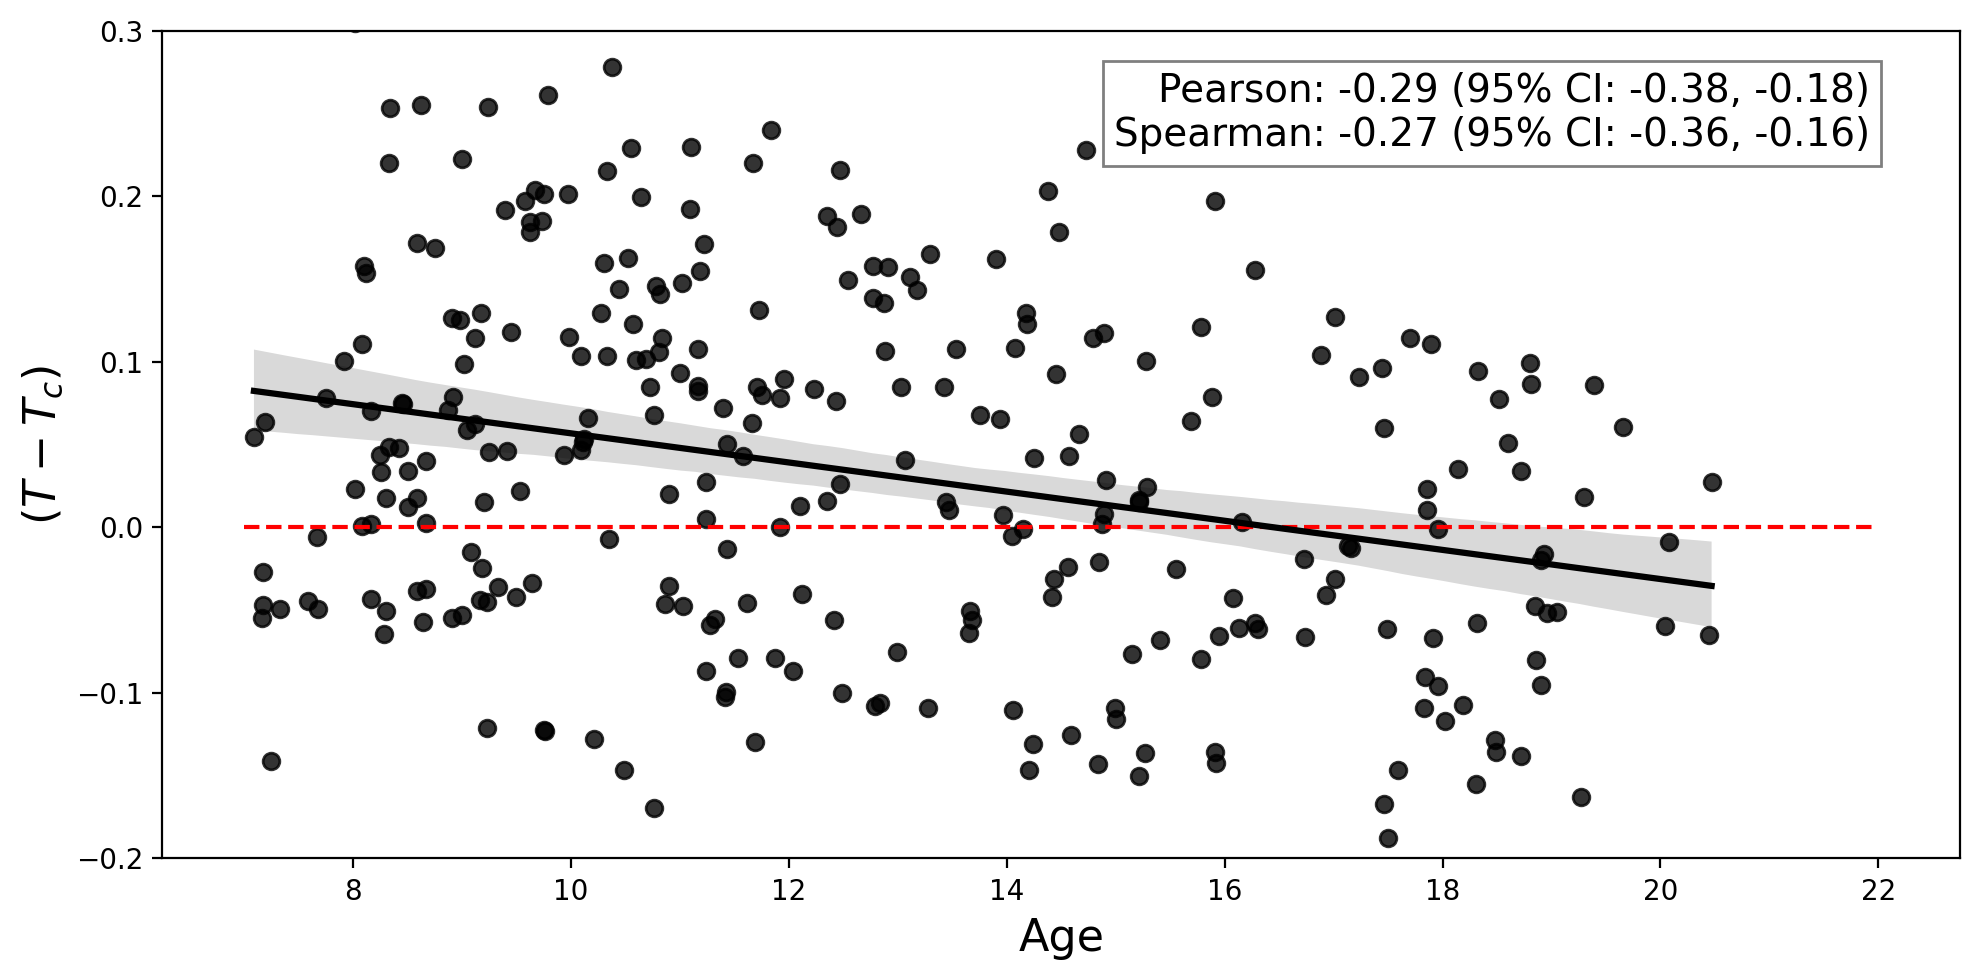

In [661]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import bootstrap

# Load data
#df = adhd_ingestion(dx=0, max_m=3)

#df = df.sample(frac=1, axis=0).iloc[:140, :]

df['Temperature'] = df['Temperature'] - 2.28

# Define correlation functions
def pearson(sample, sample2):
    return stats.pearsonr(sample, sample2).statistic

def spearman(sample, sample2):
    return stats.spearmanr(sample, sample2).statistic

# Perform bootstrap for Pearson correlation
data_for_bootstrap = (df['Age'].values, df['Temperature'].values)
results_pearson = bootstrap(
    data_for_bootstrap, pearson, paired=True, confidence_level=0.95, n_resamples=500, method='BCa'
)
pearson_conf_interval = results_pearson.confidence_interval
pearson_value = results_pearson.bootstrap_distribution.mean()
pearson_std = results_pearson.bootstrap_distribution.std()

print('Pearson', ttest_ind(results_pearson.bootstrap_distribution,0))


# Perform bootstrap for Spearman correlation
results_spearman = bootstrap(
    data_for_bootstrap, spearman, paired=True, confidence_level=0.95, n_resamples=500, method='BCa'
)
spearman_conf_interval = results_spearman.confidence_interval
spearman_value = results_spearman.bootstrap_distribution.mean()
spearman_std = results_spearman.bootstrap_distribution.std()

print('Spearman', ttest_ind(results_spearman.bootstrap_distribution,0))


# Visualization
plt.figure(figsize=(10, 5), dpi=200)
plt.hlines(0, xmin=7, xmax=22, colors='red', linestyles='dashed')
sns.regplot(data=df, x='Age', y='Temperature', color='black')

# Add text box with correlation values
text = (
    f"Pearson: {pearson_value:.2f} (95% CI: {pearson_conf_interval.low:.2f}, {pearson_conf_interval.high:.2f})\n"
    f"Spearman: {spearman_value:.2f} (95% CI: {spearman_conf_interval.low:.2f}, {spearman_conf_interval.high:.2f})"
)
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'), size=14)

# Plot formatting
plt.ylabel(r'$(T - T_c)$', size=16)
plt.xlabel('Age', size=16)
plt.ylim(-0.2, 0.3)
plt.tight_layout()
plt.show()


Pearson TtestResult(statistic=-2.818720578430336, pvalue=0.0050130835834315095, df=499.0)
Spearman TtestResult(statistic=-2.611058270649345, pvalue=0.009297865353951504, df=499.0)


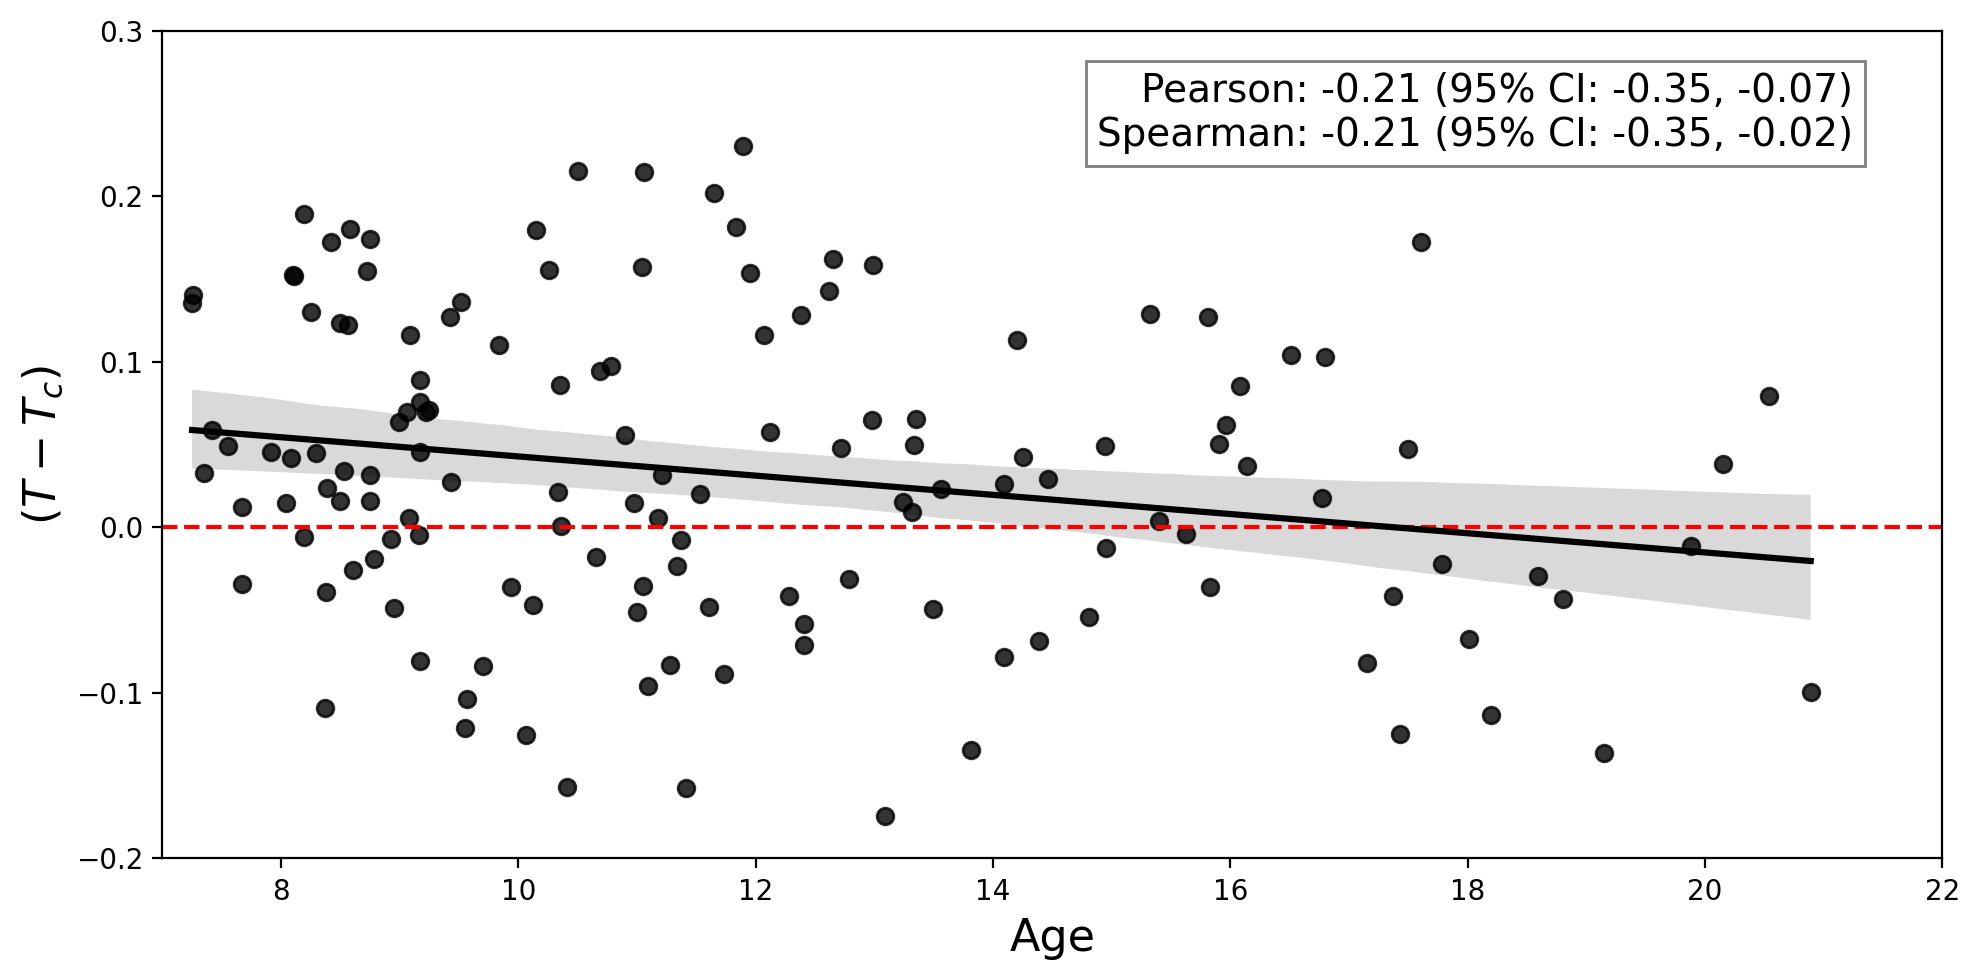

In [662]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import bootstrap

# Load ADHD data
# adhd = adhd_ingestion(dx=1, max_m=3)

adhd['Temperature'] = adhd['Temperature'] - 2.28

# Define correlation functions
def pearson(sample, sample2):
    return stats.pearsonr(sample, sample2).statistic

def spearman(sample, sample2):
    return stats.spearmanr(sample, sample2).statistic

# Perform bootstrap for Pearson correlation
data_for_bootstrap_adhd = (adhd['Age'].values, adhd['Temperature'].values)
results_pearson_adhd = bootstrap(
    data_for_bootstrap_adhd, pearson, paired=True, confidence_level=0.95, n_resamples=500, method='BCa'
)
pearson_conf_interval_adhd = results_pearson_adhd.confidence_interval
pearson_value_adhd = results_pearson_adhd.bootstrap_distribution.mean()
pearson_std_adhd = results_pearson_adhd.bootstrap_distribution.std()

print('Pearson', ttest_ind(results_pearson_adhd.bootstrap_distribution,0))

# Perform bootstrap for Spearman correlation
results_spearman_adhd = bootstrap(
    data_for_bootstrap_adhd, spearman, paired=True, confidence_level=0.95, n_resamples=500, method='BCa'
)
spearman_conf_interval_adhd = results_spearman_adhd.confidence_interval
spearman_value_adhd = results_spearman_adhd.bootstrap_distribution.mean()
spearman_std_adhd = results_spearman_adhd.bootstrap_distribution.std()

print('Spearman', ttest_ind(results_spearman_adhd.bootstrap_distribution,0))

# Visualization
plt.figure(figsize=(10, 5), dpi=200)
plt.hlines(0, xmin=7, xmax=22, colors='red', linestyles='dashed')
sns.regplot(data=adhd, x='Age', y='Temperature', color='black')

# Add text box with correlation values
text = (
    f"Pearson: {pearson_value_adhd:.2f} (95% CI: {pearson_conf_interval_adhd.low:.2f}, {pearson_conf_interval_adhd.high:.2f})\n"
    f"Spearman: {spearman_value_adhd:.2f} (95% CI: {spearman_conf_interval_adhd.low:.2f}, {spearman_conf_interval_adhd.high:.2f})"
)
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'), size=14)

# Plot formatting
plt.ylabel(r'$(T - T_c)$', size=16)
plt.xlabel('Age', size=16)
plt.ylim(-0.2, 0.3)
plt.xlim(7, 22)

plt.tight_layout()
plt.show()

In [663]:
import numpy as np
from scipy.stats import wilcoxon, ttest_ind

# Calculate mean and standard deviation for both distributions
control_mean = np.mean(control_distribution)
control_std = results_pearson.standard_error

adhd_mean = np.mean(adhd_distribution)
adhd_std = results_pearson_adhd.standard_error

# Print mean and standard deviation for both groups
print(f"Control Distribution: Mean = {control_mean:.3f}, Std = {control_std:.3f}")
print(f"ADHD Distribution: Mean = {adhd_mean:.3f}, Std = {adhd_std:.3f}")

# Perform Wilcoxon Signed-Rank Test (paired test)
wilcoxon_stat, wilcoxon_p = wilcoxon(control_distribution, adhd_distribution)
print(f"Wilcoxon Signed-Rank Test Statistic: {wilcoxon_stat:.3f}, P-value: {wilcoxon_p:.3f}")

# Perform t-test for independent samples (unpaired test)
ttest_stat, ttest_p = ttest_ind(control_distribution, adhd_distribution, equal_var=False)  # Welch's t-test
print(f"Independent T-Test Statistic: {ttest_stat:.3f}, P-value: {ttest_p:.3f}")

Control Distribution: Mean = -0.264, Std = 0.051
ADHD Distribution: Mean = -0.211, Std = 0.076
Wilcoxon Signed-Rank Test Statistic: 26285.000, P-value: 0.000
Independent T-Test Statistic: -12.584, P-value: 0.000


Wilcoxon Signed-Rank Test P-value: WilcoxonResult(statistic=15457.0, pvalue=3.131133075905549e-48)
P-value for the difference between the two distributions: TtestResult(statistic=-17.834736264907868, pvalue=5.674466383976648e-62, df=998.0)


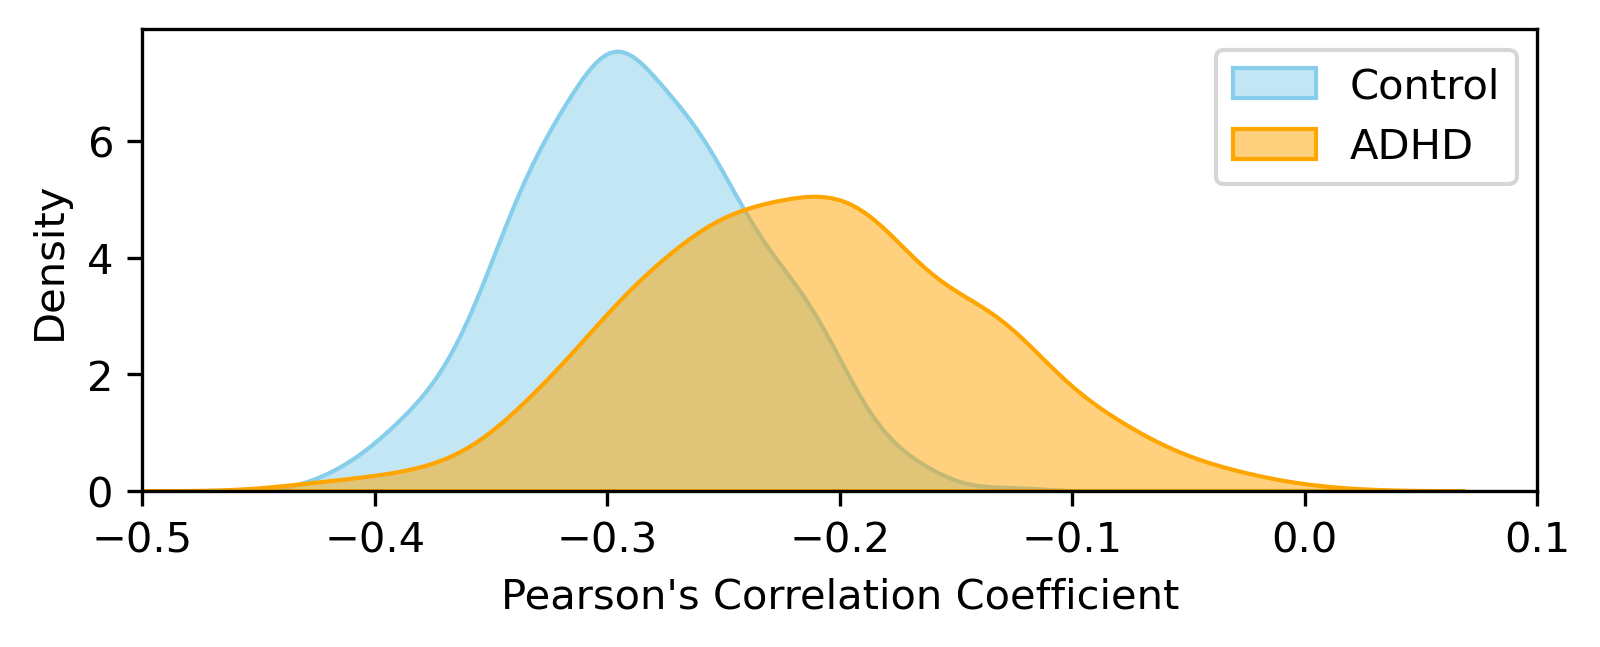

In [664]:
from scipy.stats import ttest_ind

# Extract bootstrap distributions
control_distribution = results_pearson.bootstrap_distribution
adhd_distribution = results_pearson_adhd.bootstrap_distribution

from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank test
print(f"Wilcoxon Signed-Rank Test P-value: {wilcoxon(control_distribution, adhd_distribution)}")
# Print the p-value
print(f"P-value for the difference between the two distributions: {ttest_ind(control_distribution, adhd_distribution)}")

# Visualization
plt.figure(dpi=300, figsize=(6, 2))
sns.kdeplot(control_distribution, fill=True, color="skyblue", alpha=0.5, linewidth=1, label='Control')
sns.kdeplot(adhd_distribution, fill=True, color='orange', alpha=0.5, linewidth=1, label='ADHD')

plt.xlabel("Pearson's Correlation Coefficient")
plt.ylabel('Density')
plt.xlim(-0.5, 0.1)
plt.legend()
plt.show()

mannwhitneyu Test P-value: MannwhitneyuResult(statistic=74274.0, pvalue=1.1489544710221202e-28)
P-value for the difference between the two distributions: TtestResult(statistic=-12.016879458861283, pvalue=3.6498184295282037e-31, df=998.0)


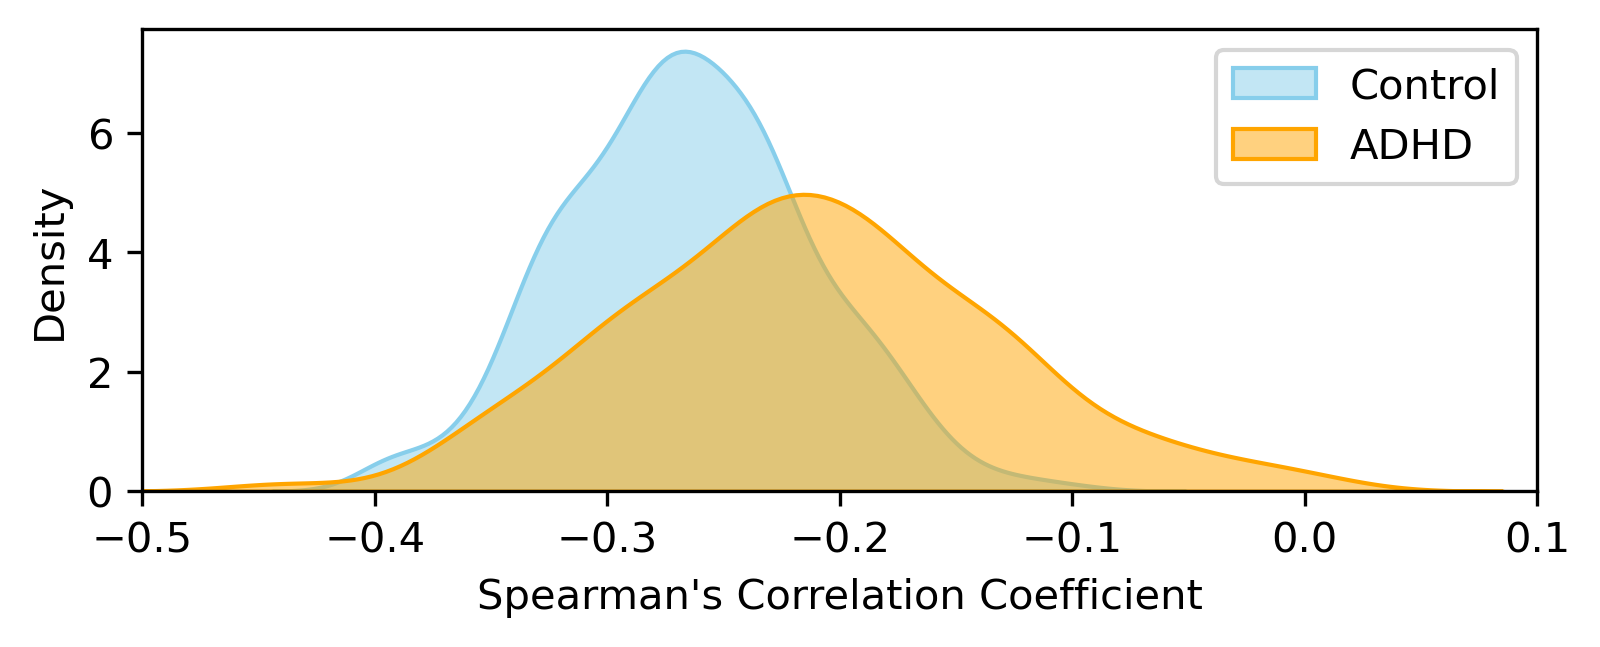

In [665]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu


# Extract bootstrap distributions
control_distribution = results_spearman.bootstrap_distribution
adhd_distribution = results_spearman_adhd.bootstrap_distribution

print(f"mannwhitneyu Test P-value: {mannwhitneyu(control_distribution, adhd_distribution)}")
# Print the p-value
print(f"P-value for the difference between the two distributions: {ttest_ind(control_distribution, adhd_distribution)}")

# Visualization
plt.figure(dpi=300, figsize=(6, 2))
sns.kdeplot(control_distribution, fill=True, color="skyblue", alpha=0.5, linewidth=1, label='Control')
sns.kdeplot(adhd_distribution, fill=True, color='orange', alpha=0.5, linewidth=1, label='ADHD')

plt.xlabel("Spearman's Correlation Coefficient")
plt.ylabel('Density')
plt.xlim(-0.5, 0.1)
plt.legend()
plt.show()

In [666]:
stats.ttest_ind(bootstrap_samples, bootstrap_samples_adhd)

TtestResult(statistic=-2.1777172928689303, pvalue=0.02954371437504455, df=1998.0)

## Analysis of DX

In [667]:
df_dx1 = adhd_ingestion(dx=1, max_m=1.5)
df_dx2 = adhd_ingestion(dx=2, max_m=1.5)
df_dx3 = adhd_ingestion(dx=3, max_m=1.5)

/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_64142/823079007.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Documents/data/Thesis/adhd_dataset_gordon.csv')
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_64142/823079007.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_

In [32]:
df = df[df.Age <= 10]

df_dx1 = df_dx1[df_dx1.Age <= 10]
df_dx2 = df_dx2[df_dx2.Age <= 10]
df_dx3 = df_dx3[df_dx3.Age <= 10]

In [281]:
print(df.shape)
print(df_dx1.shape)
print(df_dx2.shape)
print(df_dx3.shape)

(64, 7)
(24, 7)
(1, 7)
(11, 7)


In [282]:
all_arr = [df['Temperature'], df_dx1['Temperature'], df_dx2['Temperature'], df_dx3['Temperature']]

Text(0.5, 0, 'DX')

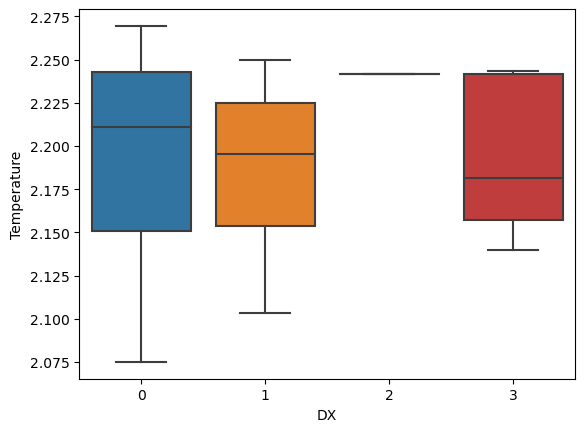

In [283]:
sns.boxplot(all_arr)
plt.ylabel('Temperature')
plt.xlabel('DX')

In [284]:
all_arr = [df['Temperature'], pd.concat([df_dx1, df_dx2,df_dx3])['Temperature']]

In [285]:
stats.ttest_ind(all_arr[0], all_arr[1])

Ttest_indResult(statistic=0.838767579085059, pvalue=0.40364102807491475)

Text(0.5, 0, 'DX')

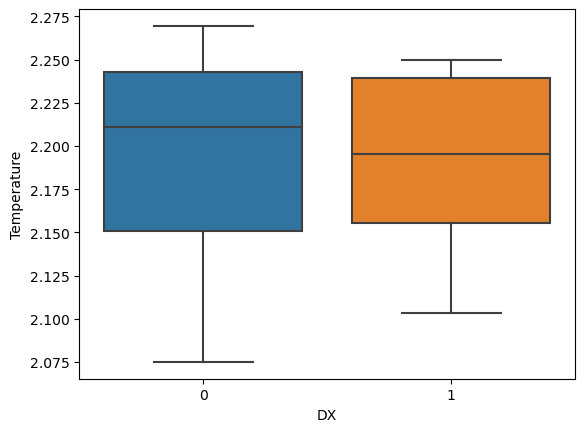

In [286]:
sns.boxplot(all_arr)
plt.ylabel('Temperature')
plt.xlabel('DX')

In [185]:
all_arr = [df[' Max Rotation (degree)'], df_dx1[' Max Rotation (degree)'], df_dx2[' Max Rotation (degree)'], df_dx3[' Max Rotation (degree)']]

In [186]:
sns.boxplot(df_all)
plt.ylabel('Max Rotation (degree)')
plt.xlabel('DX')

NameError: name 'df_all' is not defined

## Constency over the same subject

In [38]:
df = runs(dx=0, max_m=1)

/Users/rodrigo/Post-Grad/Ising_GNN/utils.py:356: FutureWarning: The default value of regex will change from True to False in a future version.
  motion['Subject'] = motion['Subject'].str.replace(r'^(0+)', '').fillna('0')


In [39]:
df = df.set_index(['Institution', 'Subject', 'Run']) 

In [40]:
std = df.groupby(level=['Institution','Subject']).std()['Temperature'].dropna()
motion = df.groupby(level=['Institution','Subject']).mean()['Max Motion (mm)'].dropna()

common_indices = motion.index.intersection(std.index)
motion = motion.loc[common_indices]

Pearson Temperature and Age = 0.16194416855935584


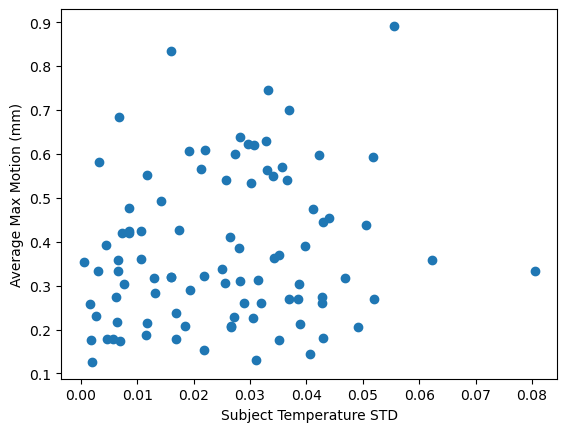

In [41]:
plt.scatter(std,motion)
plt.ylabel('Average Max Motion (mm)')
plt.xlabel('Subject Temperature STD')

print('Pearson STD Temperature and Average Max Motion (mm) = {}'.format(np.corrcoef([std, motion])[0,1]))

Text(0.5, 0, 'Subject Temperature STD')

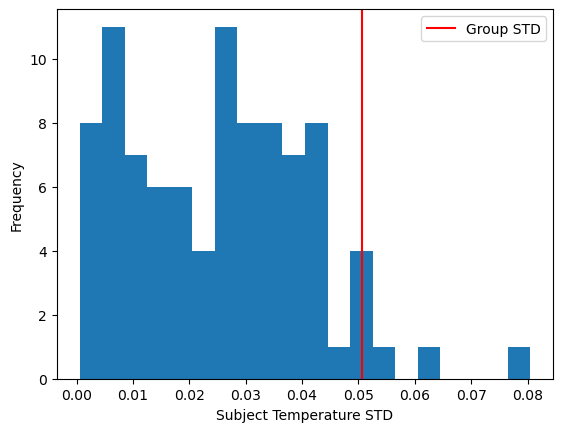

In [42]:
plt.hist(std, bins=20)
#plt.hist(motion)
plt.axvline(df['Temperature'].std(),color='red', label='Group STD')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Subject Temperature STD')

Text(0, 0.5, 'Subject Temperature STD')

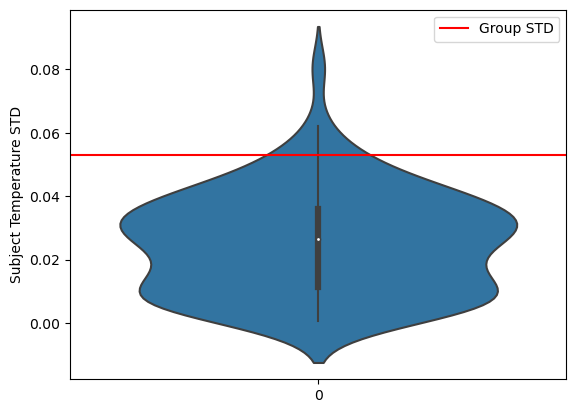

In [101]:
sns.violinplot(std)
#plt.hist(motion)
plt.axhline(df['Temperature'].std(),color='red', label='Group STD')
plt.legend()
#plt.ylabel('Frequency')
plt.ylabel('Subject Temperature STD')